In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [ ]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [ ]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  ...  PLNUSD=X  RUBUSD=X  SEKUSD=X
Date                                      ...                              
2016-02-01  0.706864  0.715676  0.976086  ...  0.245228  0.013256  0.116426
2016-02-02  0.711086  0.716846  0.980873  ...  0.247986  0.012943  0.117306
2016-02-03  0.702988  0.711238  0.981653  ...  0.248004  0.012545  0.116964
2016-02-04  0.715461  0.724942  0.994827  ...  0.251062  0.012999  0.118491
2016-02-05  0.719942  0.726998  1.006654  ...  0.253291  0.013026  0.119067

[5 rows x 15 columns]

In [ ]:
data['Close'].describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [ ]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [ ]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [ ]:
new_data.

AUDUSD=X    0.001055
CADUSD=X    0.000599
CHFUSD=X    0.000605
CNYUSD=X    0.000148
DKKUSD=X    0.000187
EURUSD=X    0.001396
GBPUSD=X    0.001936
HKDUSD=X    0.000018
JPYUSD=X    0.000009
KZTUSD=X    0.000006
NOKUSD=X    0.000154
NZDUSD=X    0.000914
PLNUSD=X    0.000415
RUBUSD=X    0.000033
SEKUSD=X    0.000204
dtype: float64

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# new_data['day'] = new_data.index.day
# new_data['month'] = new_data.index.month

In [ ]:
values = new_data.values
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665],
       [0.70013791, 0.76566166, 1.03238595, ..., 0.26333806, 0.01613655,
        0.10701276]])

In [ ]:
values = np.diff(values, axis=0)
values.shape

(1018, 15)

In [ ]:
values.shape

(1018, 15)

In [ ]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
scaled

array([[0.6775344 , 0.5246035 , 0.6457172 , ..., 0.88013524, 0.33493066,
        0.7740201 ],
       [0.27304694, 0.26754618, 0.5037401 , ..., 0.7104205 , 0.26477882,
        0.60677946],
       [0.9484288 , 1.        , 0.94287044, ..., 0.8987504 , 0.95750606,
        0.8624318 ],
       ...,
       [0.60998154, 0.5836144 , 0.39980996, ..., 0.71604407, 0.5115896 ,
        0.6424666 ],
       [0.6591497 , 0.5568159 , 0.763803  , ..., 0.82587445, 0.6148677 ,
        0.77575165],
       [0.5992677 , 0.5086759 , 0.6669412 , ..., 0.7619336 , 0.6055122 ,
        0.6242666 ]], dtype=float32)

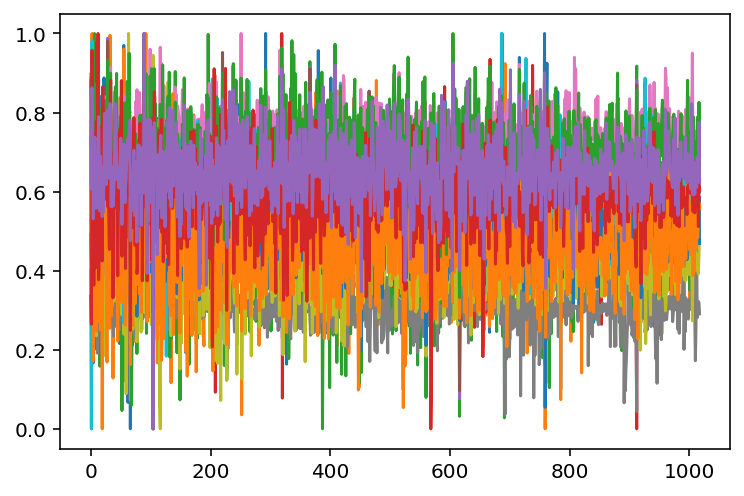

In [ ]:
plt.plot(scaled)
plt.show()

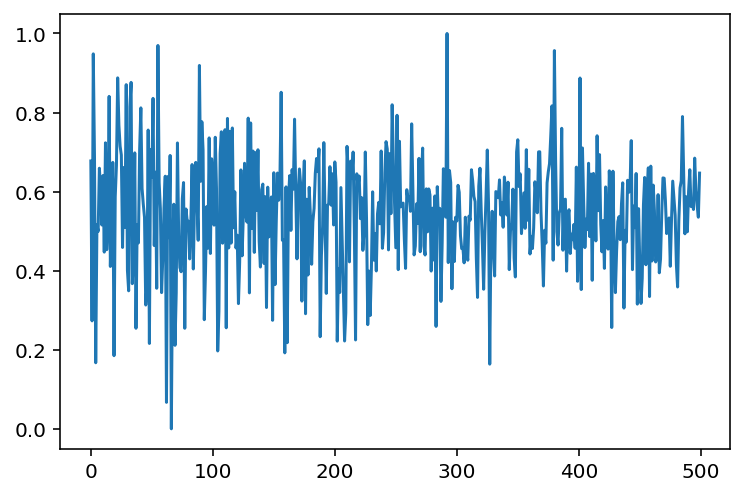

In [ ]:
plt.plot(scaled[:,0][0:500])

In [ ]:
# specify the number of lag hours
n_hours = 30
n_features = scaled.shape[1]
n_predict = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(988, 465)


In [ ]:
reframed.head()

var1(t-30)  var2(t-30)  var3(t-30)  ...  var13(t)  var14(t)  var15(t)
30    0.677534    0.524603    0.645717  ...  0.668562  0.529875  0.634377
31    0.273047    0.267546    0.503740  ...  0.673671  0.453603  0.708541
32    0.948429    1.000000    0.942870  ...  0.877086  0.793943  0.822896
33    0.686039    0.558197    0.895149  ...  0.899848  0.881446  0.759289
34    0.167087    0.226434    0.497305  ...  0.694174  0.551942  0.562023

[5 rows x 465 columns]

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [ ]:
# split into input and outputs
n_obs = n_hours * n_features

In [ ]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 450) (500, 15)
(500, 30, 15) (500, 15) (488, 30, 15) (488, 15)


In [ ]:
train_X[0]

array([[0.6775344 , 0.5246035 , 0.6457172 , 0.5281661 , 0.7353773 ,
        0.7379757 , 0.88594586, 0.399907  , 0.4901465 , 0.8970236 ,
        0.49045506, 0.6992254 , 0.88013524, 0.33493066, 0.7740201 ],
       [0.27304694, 0.26754618, 0.5037401 , 0.53316915, 0.6353702 ,
        0.64226115, 0.7480465 , 0.        , 0.5587096 , 0.        ,
        0.42706388, 0.39468855, 0.7104205 , 0.26477882, 0.60677946],
       [0.9484288 , 1.        , 0.94287044, 0.55647856, 0.9466119 ,
        0.9383874 , 0.8822609 , 0.3441781 , 0.6694964 , 0.9809575 ,
        0.7099013 , 0.8529087 , 0.8987504 , 0.95750606, 0.8624318 ],
       [0.6860389 , 0.5581971 , 0.8951491 , 0.6088106 , 0.8120324 ,
        0.81510586, 0.7576919 , 0.38215744, 0.6051128 , 0.64786583,
        0.5838646 , 0.7200965 , 0.84737015, 0.6105993 , 0.7324641 ],
       [0.16708672, 0.22643408, 0.4973053 , 0.4902901 , 0.46927235,
        0.47866577, 0.71349055, 0.2784312 , 0.4086051 , 0.5298647 ,
        0.38538587, 0.17146161, 0.6822601 , 

In [ ]:
train_y[0]

array([0.40071854, 0.40015057, 0.31830123, 0.51419544, 0.44863462,
       0.45600373, 0.6935695 , 0.33111787, 0.41292238, 0.57829416,
       0.3930868 , 0.30379587, 0.6685615 , 0.5298754 , 0.6343767 ],
      dtype=float32)

In [ ]:
values[:,0][0:n_hours+n_predict]

array([0.6775344 , 0.27304694, 0.9484288 , 0.6860389 , 0.16708672,
       0.5158604 , 0.49949706, 0.6592358 , 0.6053751 , 0.5156118 ,
       0.6407943 , 0.44701988, 0.72343653, 0.4530059 , 0.5154416 ,
       0.8409109 , 0.4107279 , 0.53551704, 0.6739416 , 0.18500766,
       0.5873915 , 0.66691256, 0.8877563 , 0.76778495, 0.7149046 ,
       0.69262576, 0.45882758, 0.66107917, 0.50963163, 0.8705828 ,
       0.40071854], dtype=float32)

Train on 500 samples, validate on 488 samples
Epoch 1/100
 - 2s - loss: 0.2668 - val_loss: 0.1694
Epoch 2/100
 - 1s - loss: 0.1210 - val_loss: 0.0634
Epoch 3/100
 - 1s - loss: 0.0437 - val_loss: 0.0234
Epoch 4/100
 - 1s - loss: 0.0237 - val_loss: 0.0178
Epoch 5/100
 - 1s - loss: 0.0193 - val_loss: 0.0127
Epoch 6/100
 - 1s - loss: 0.0158 - val_loss: 0.0102
Epoch 7/100
 - 1s - loss: 0.0145 - val_loss: 0.0098
Epoch 8/100
 - 1s - loss: 0.0139 - val_loss: 0.0101
Epoch 9/100
 - 1s - loss: 0.0136 - val_loss: 0.0091
Epoch 10/100
 - 1s - loss: 0.0131 - val_loss: 0.0088
Epoch 11/100
 - 1s - loss: 0.0130 - val_loss: 0.0090
Epoch 12/100
 - 1s - loss: 0.0130 - val_loss: 0.0089
Epoch 13/100
 - 1s - loss: 0.0129 - val_loss: 0.0089
Epoch 14/100
 - 1s - loss: 0.0128 - val_loss: 0.0088
Epoch 15/100
 - 1s - loss: 0.0128 - val_loss: 0.0087
Epoch 16/100
 - 1s - loss: 0.0128 - val_loss: 0.0088
Epoch 17/100
 - 1s - loss: 0.0128 - val_loss: 0.0087
Epoch 18/100
 - 1s - loss: 0.0128 - val_loss: 0.0087
Epoch 19/

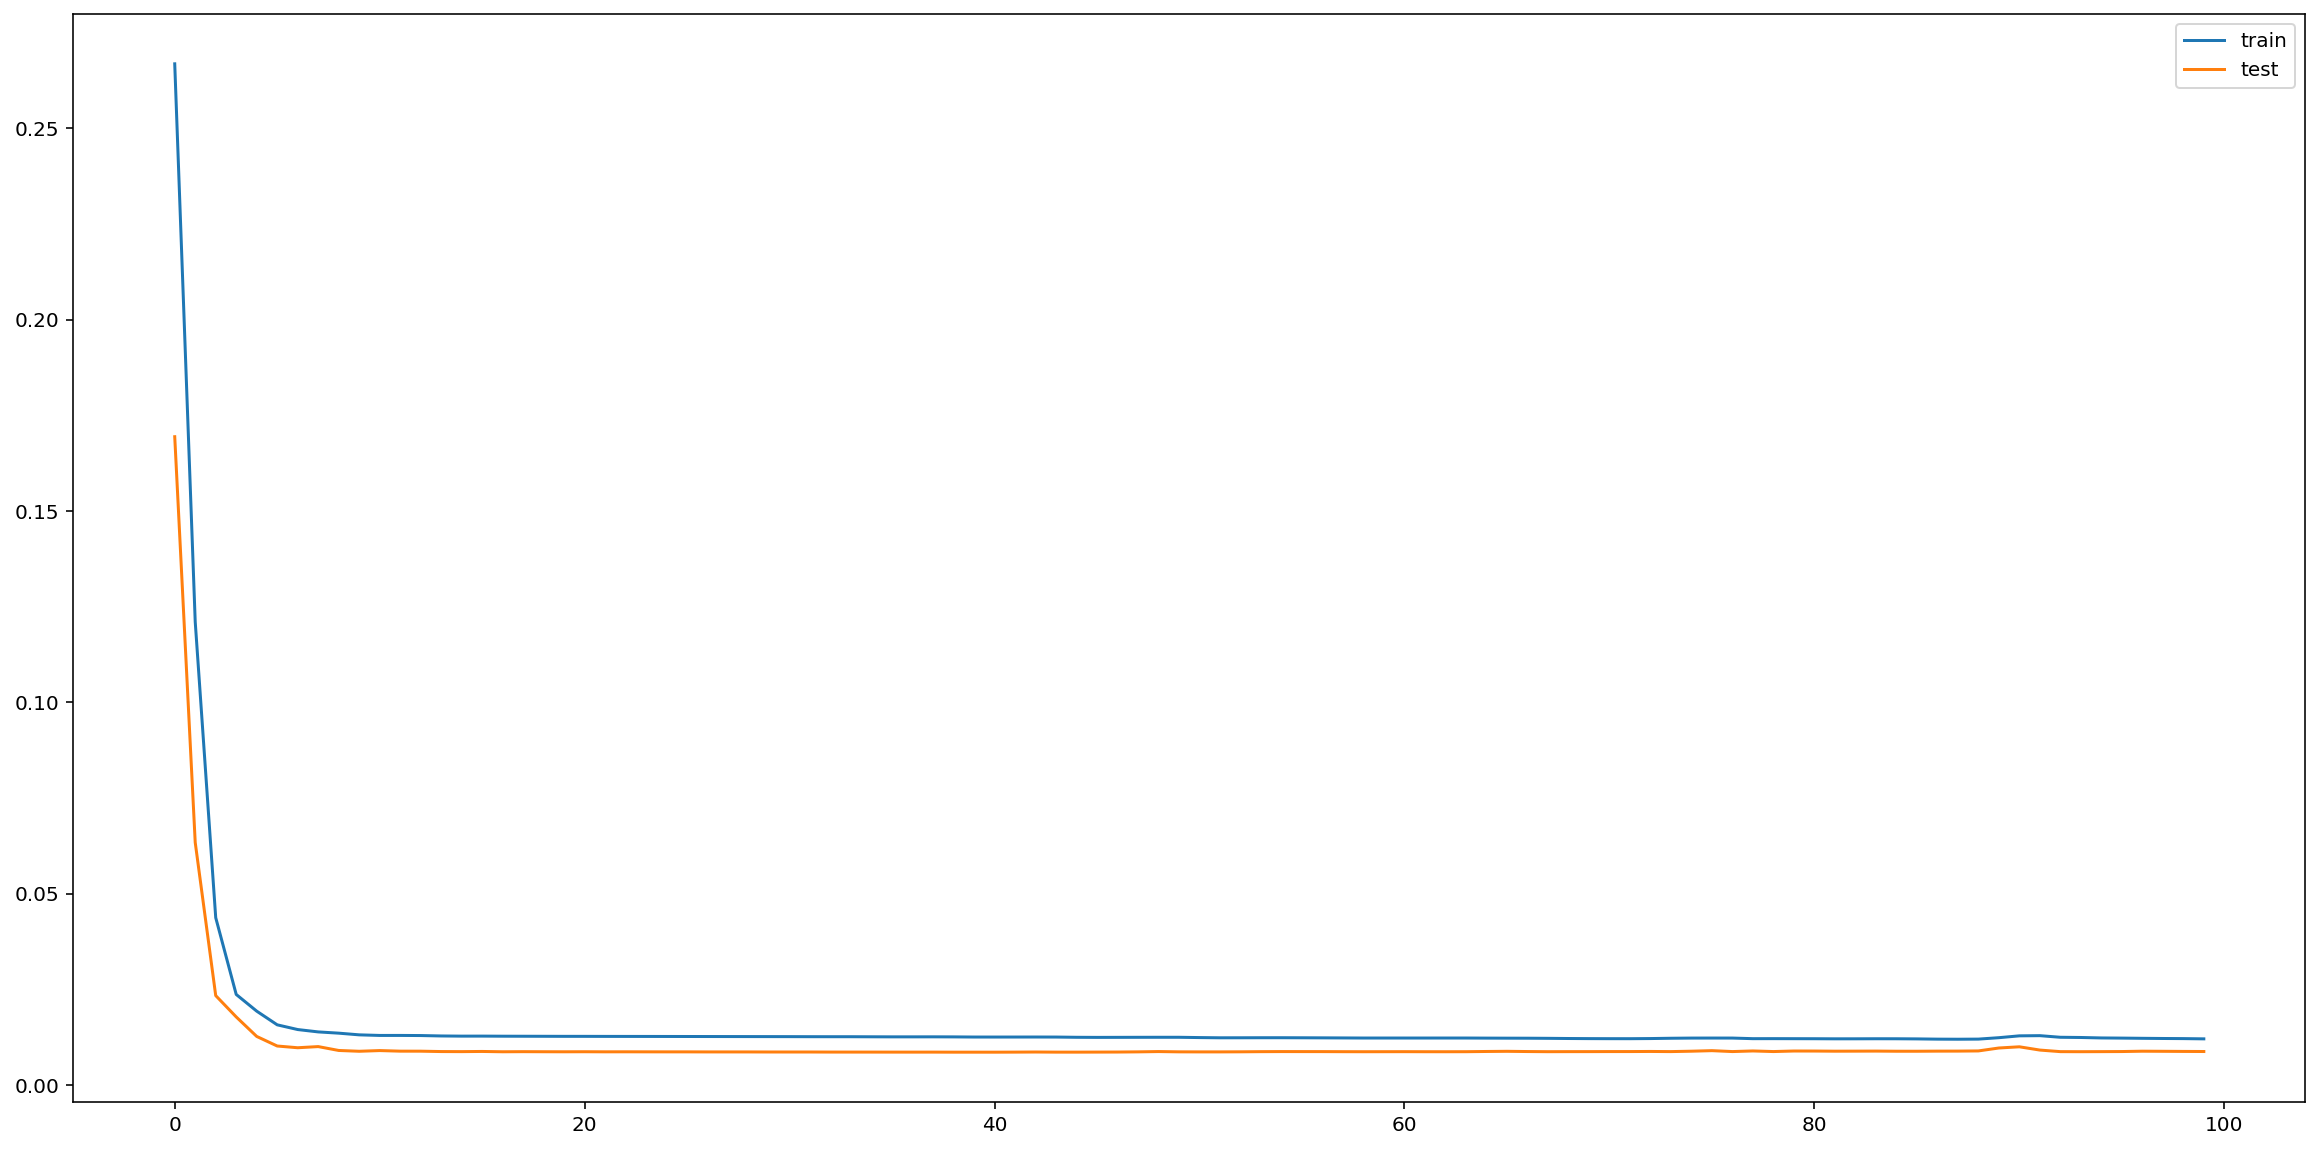

In [ ]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
y_hat = scaler.inverse_transform(test_y)
y_pred = scaler.inverse_transform(model.predict(test_X))

In [ ]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

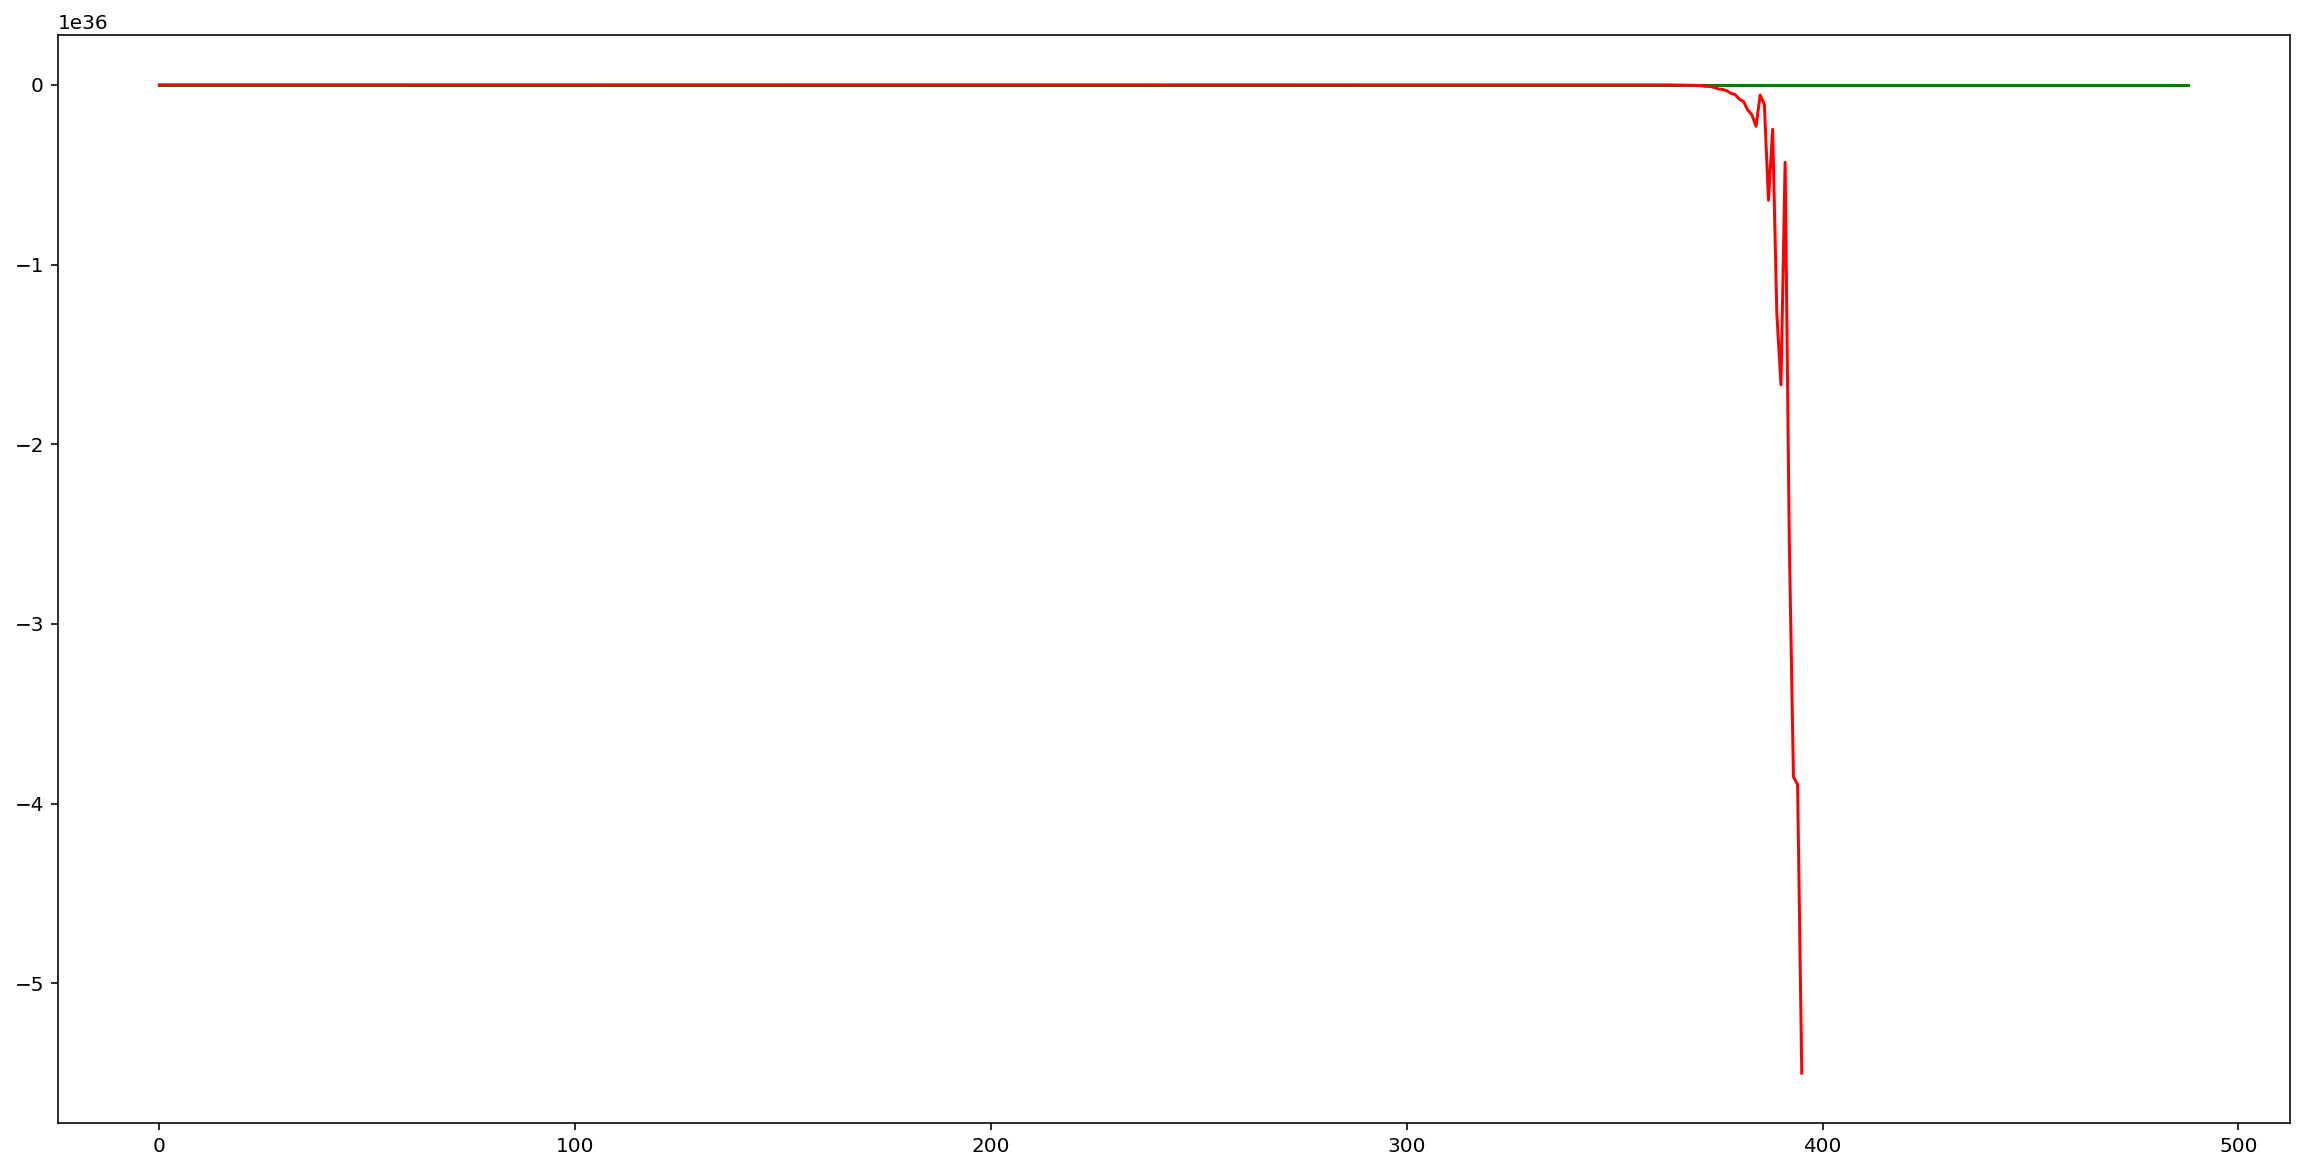

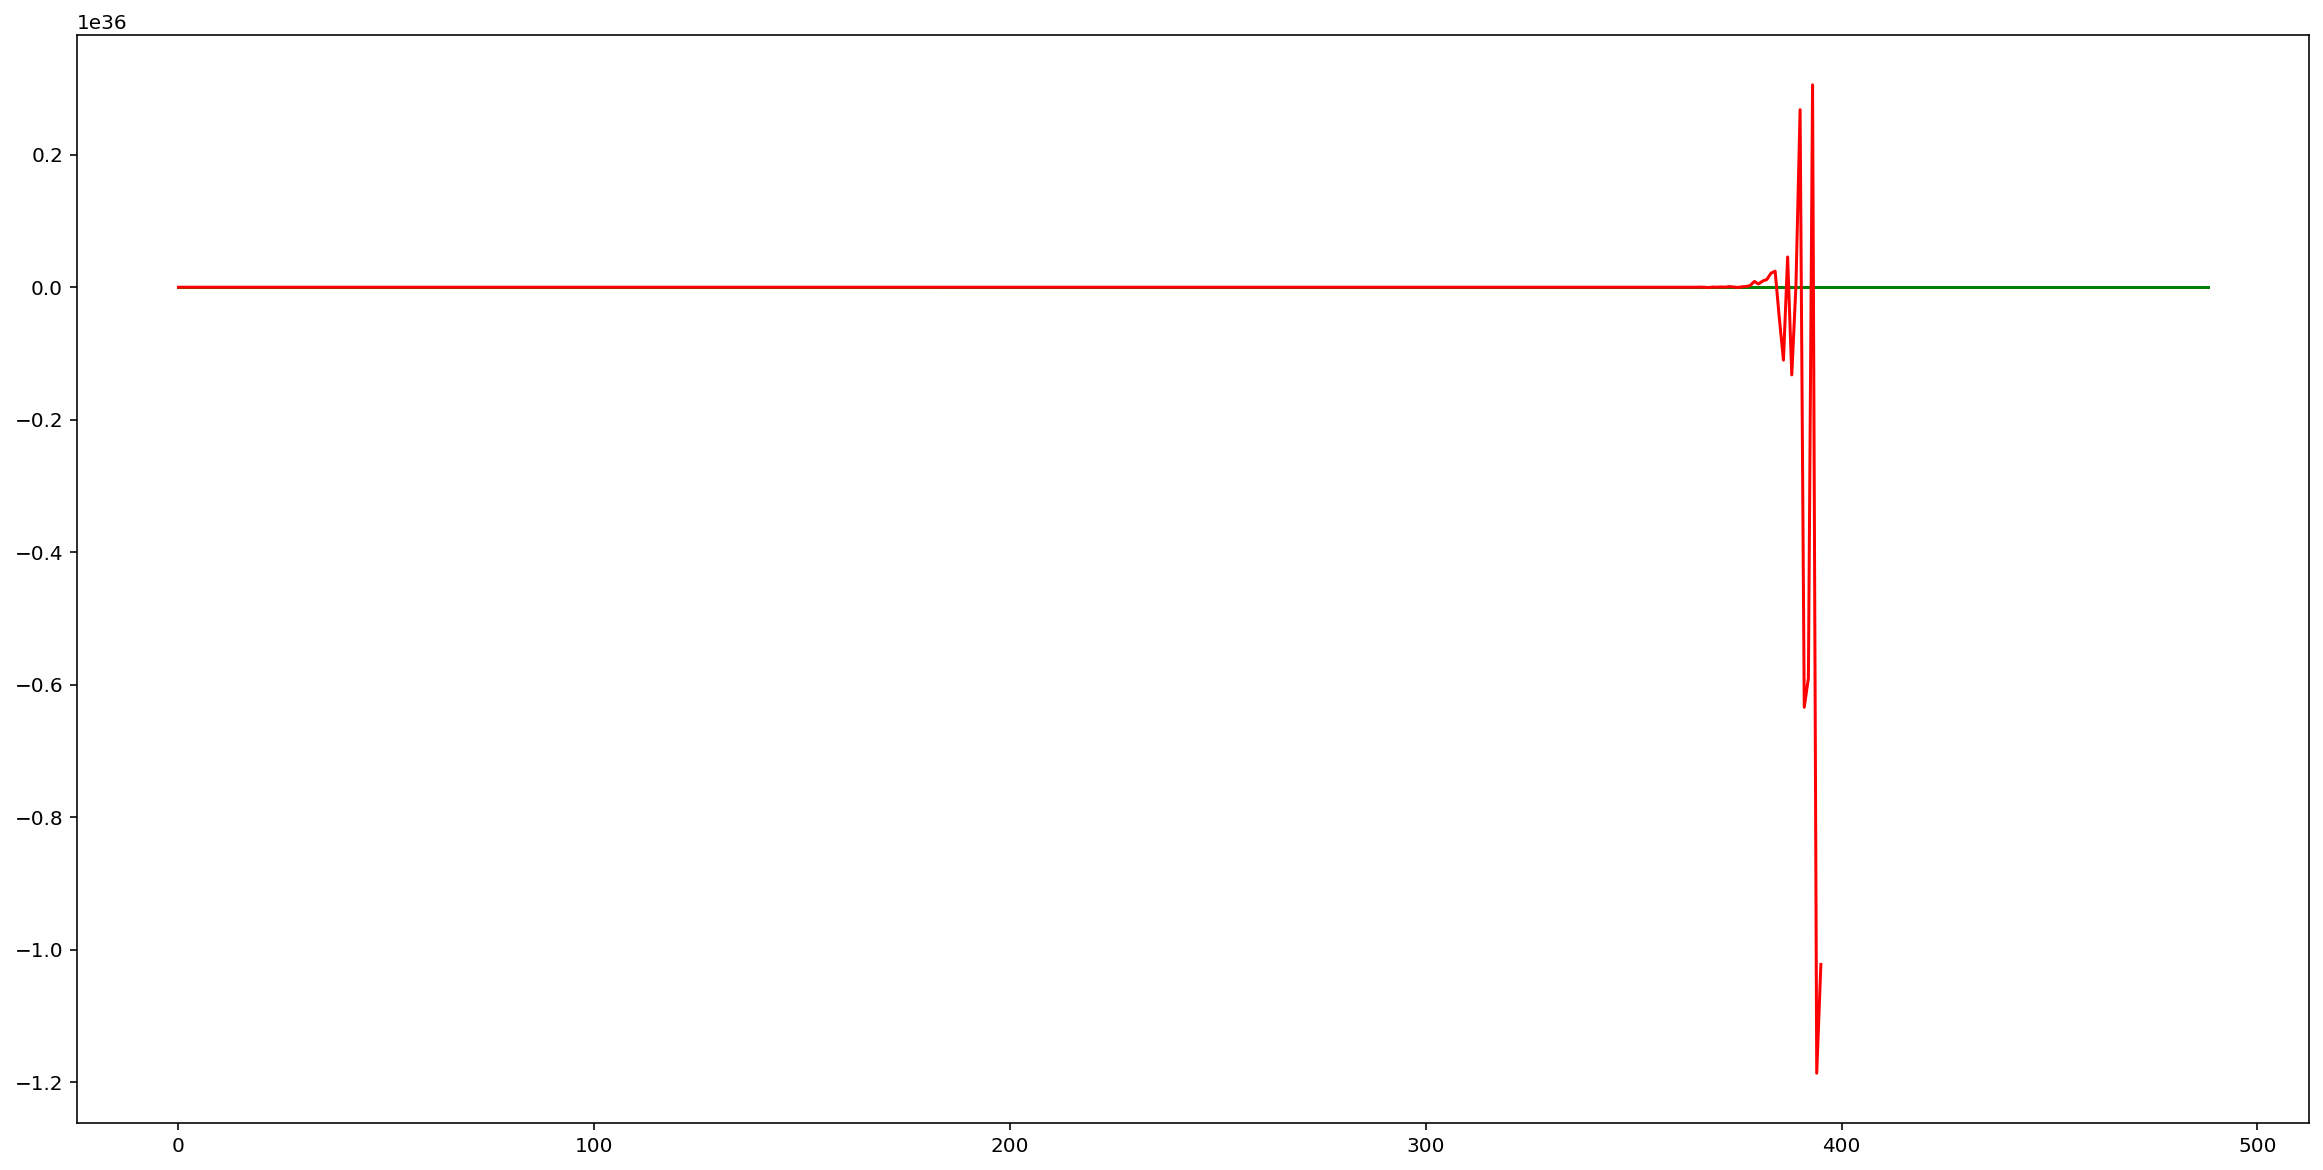

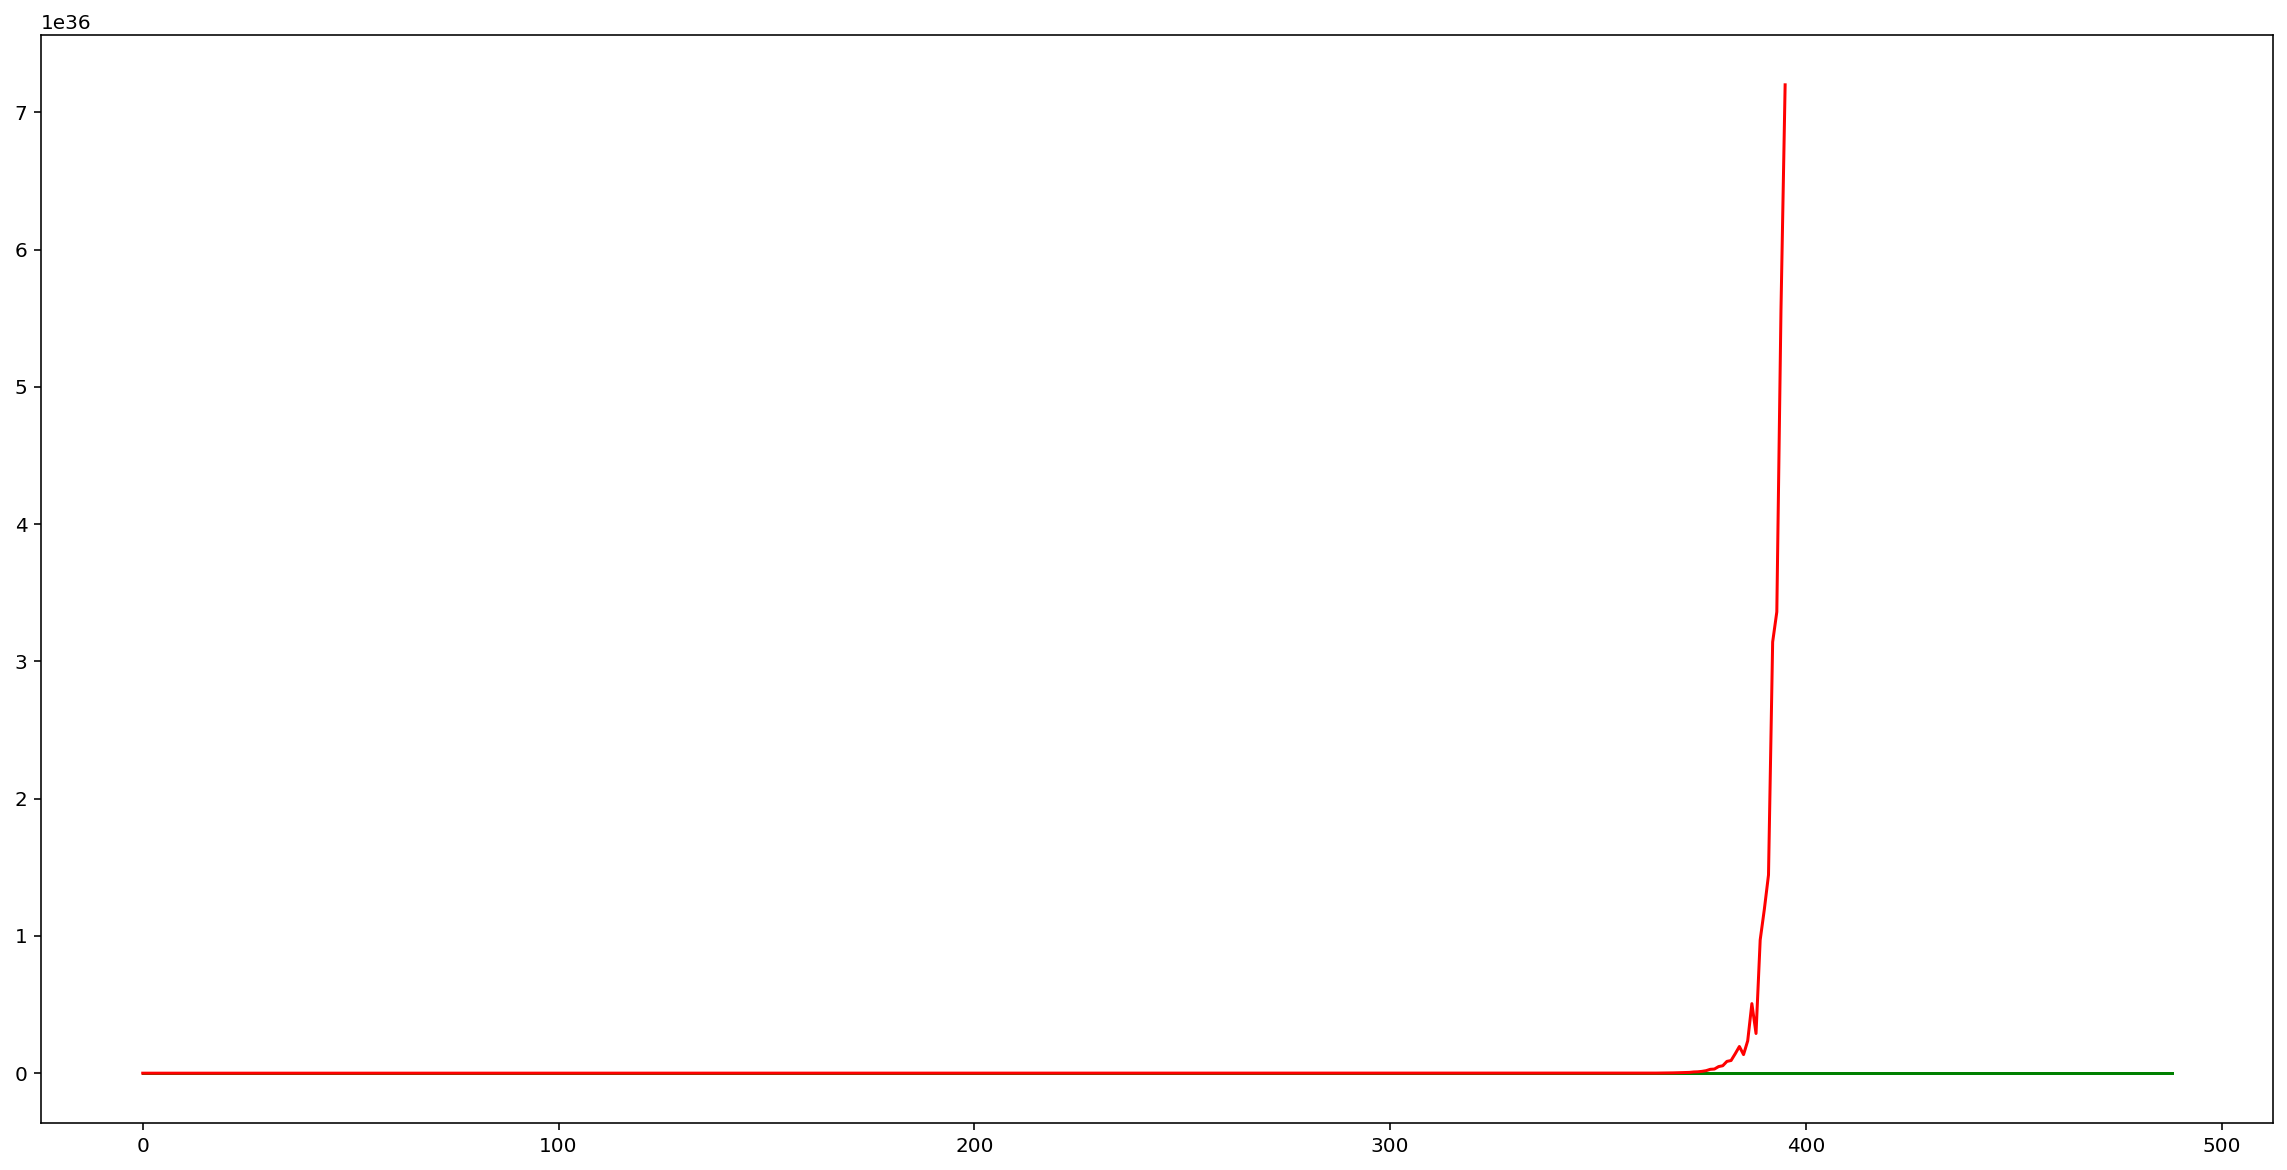

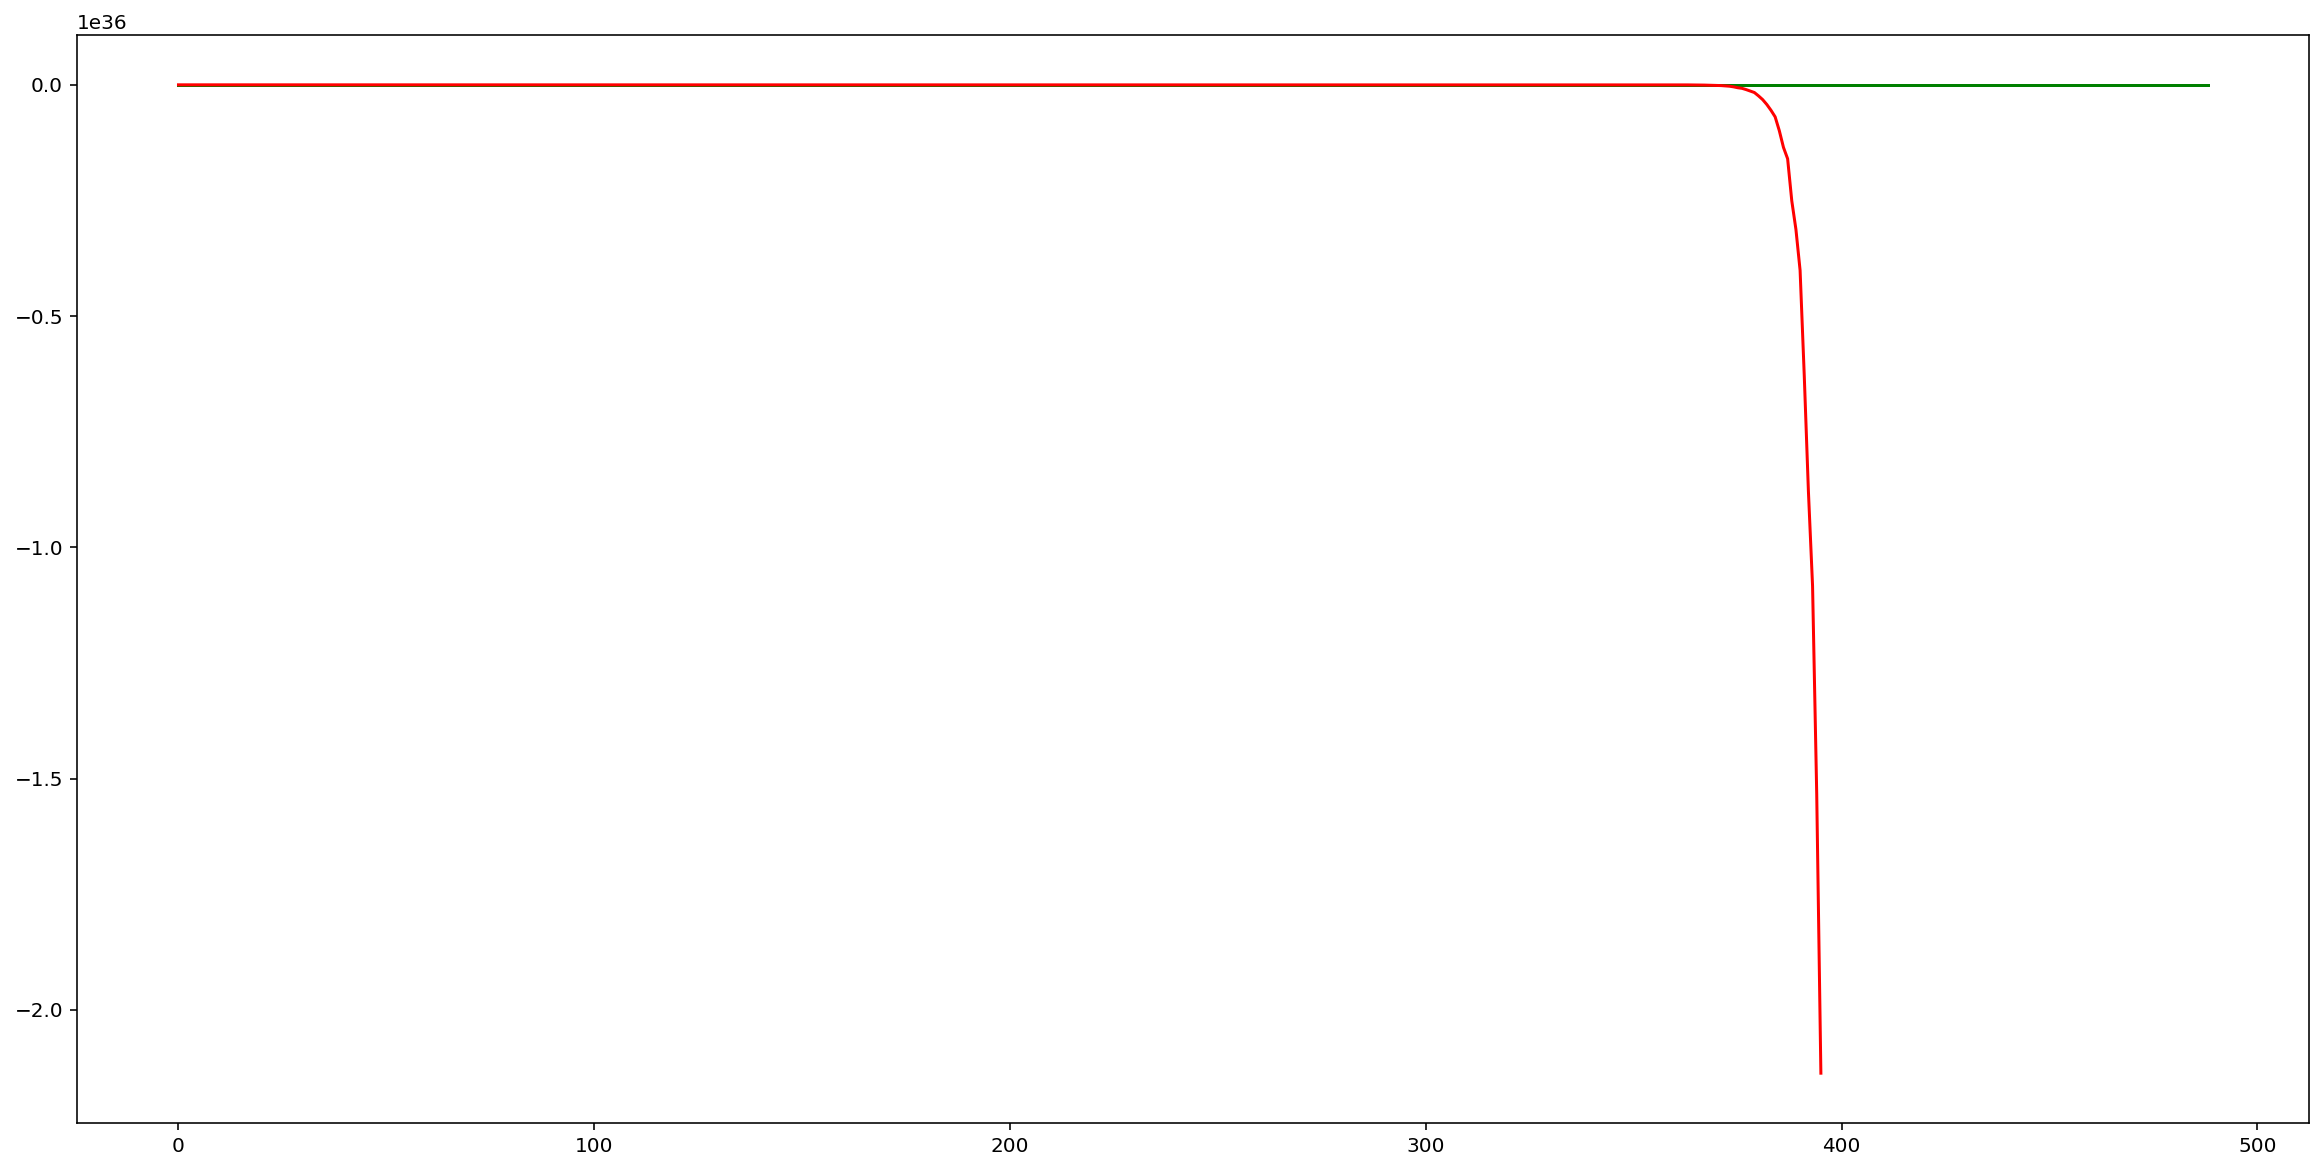

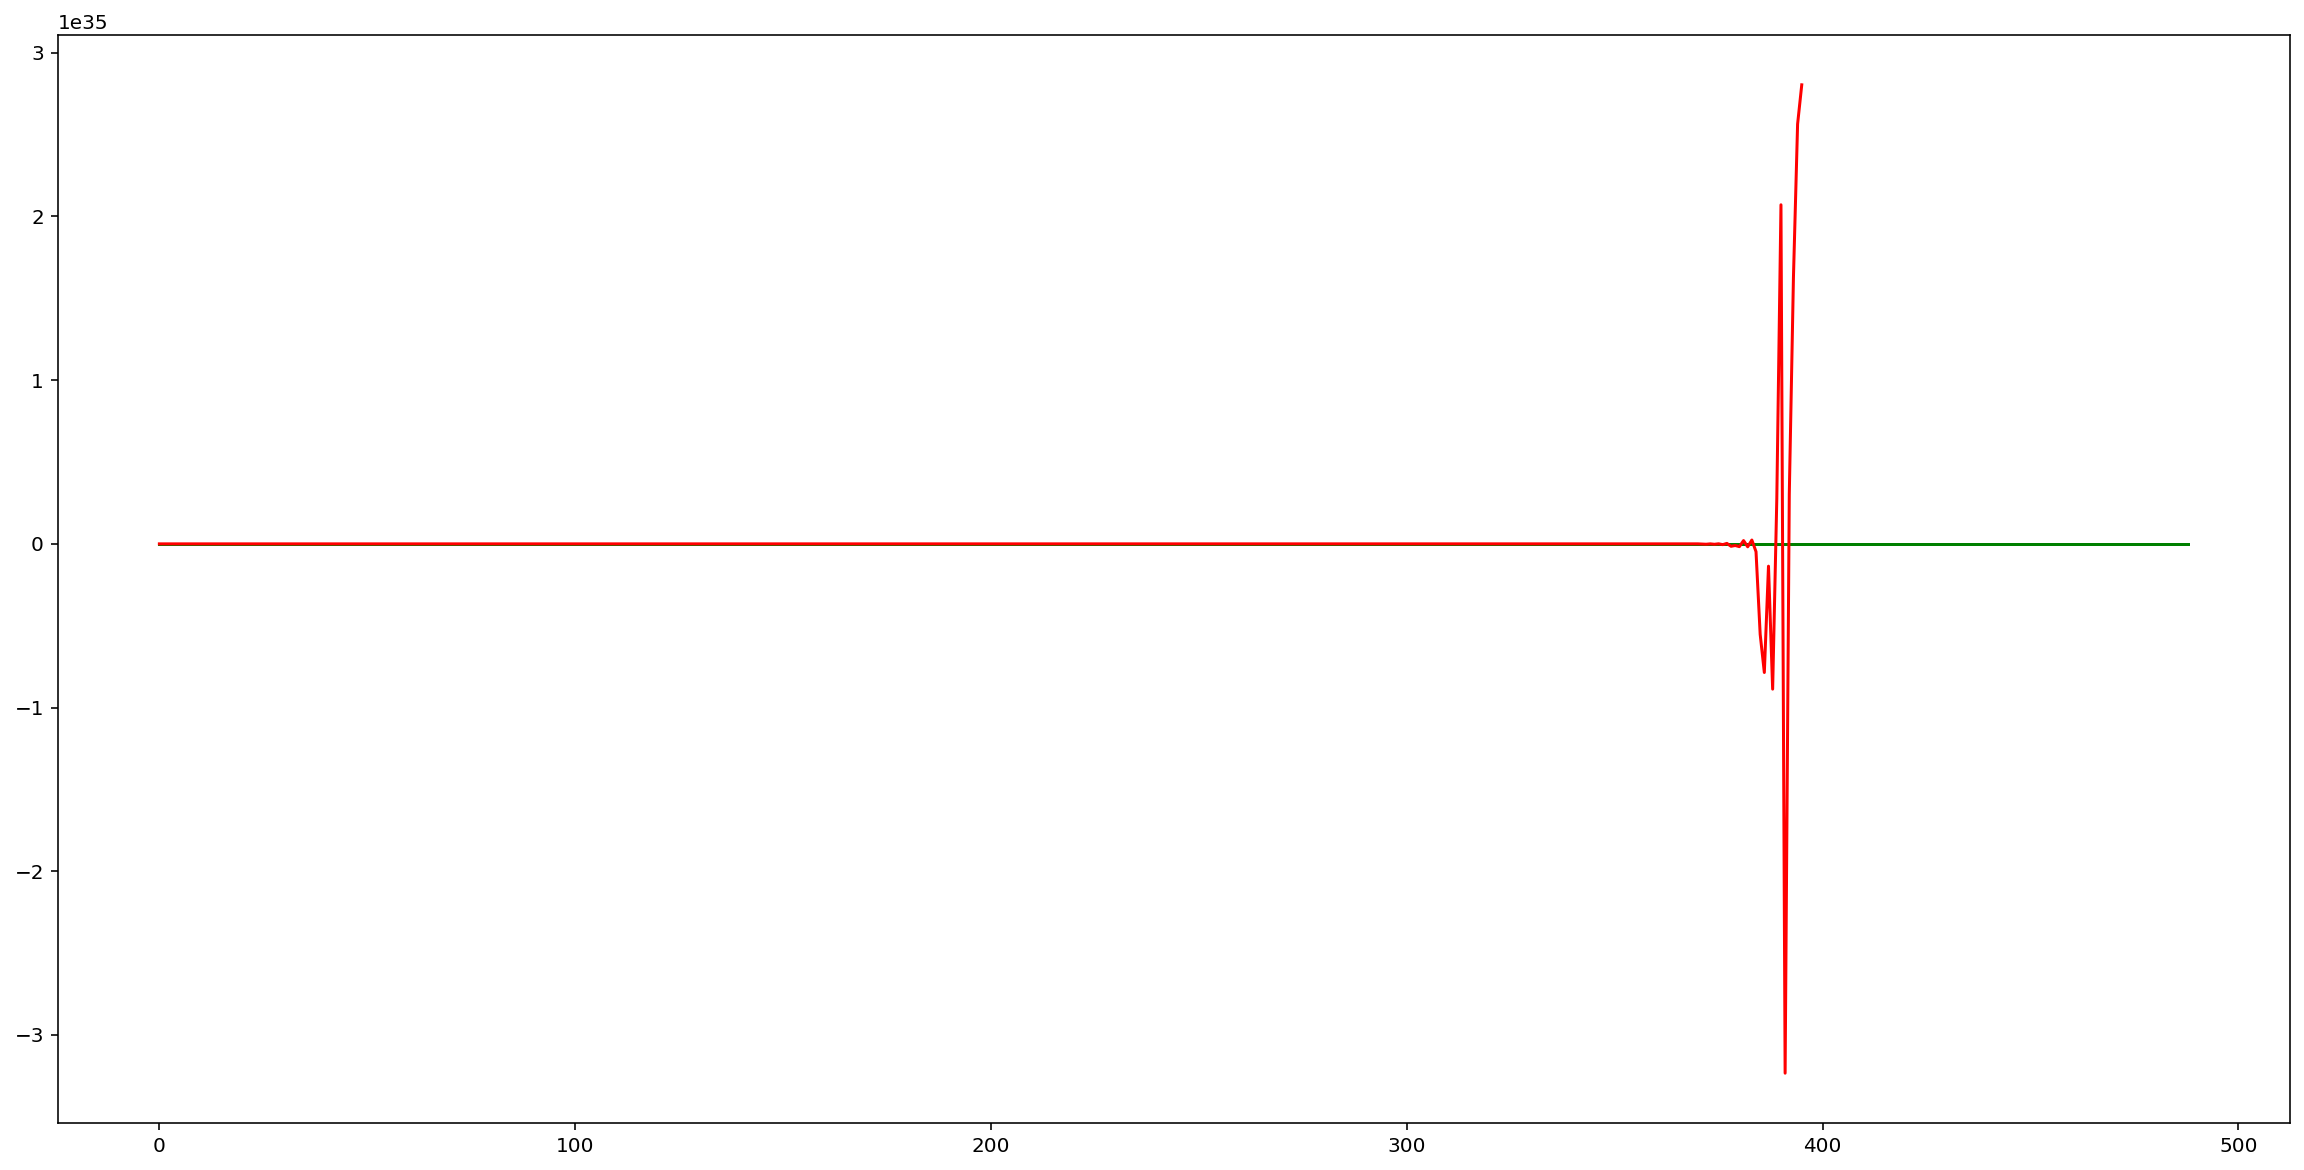

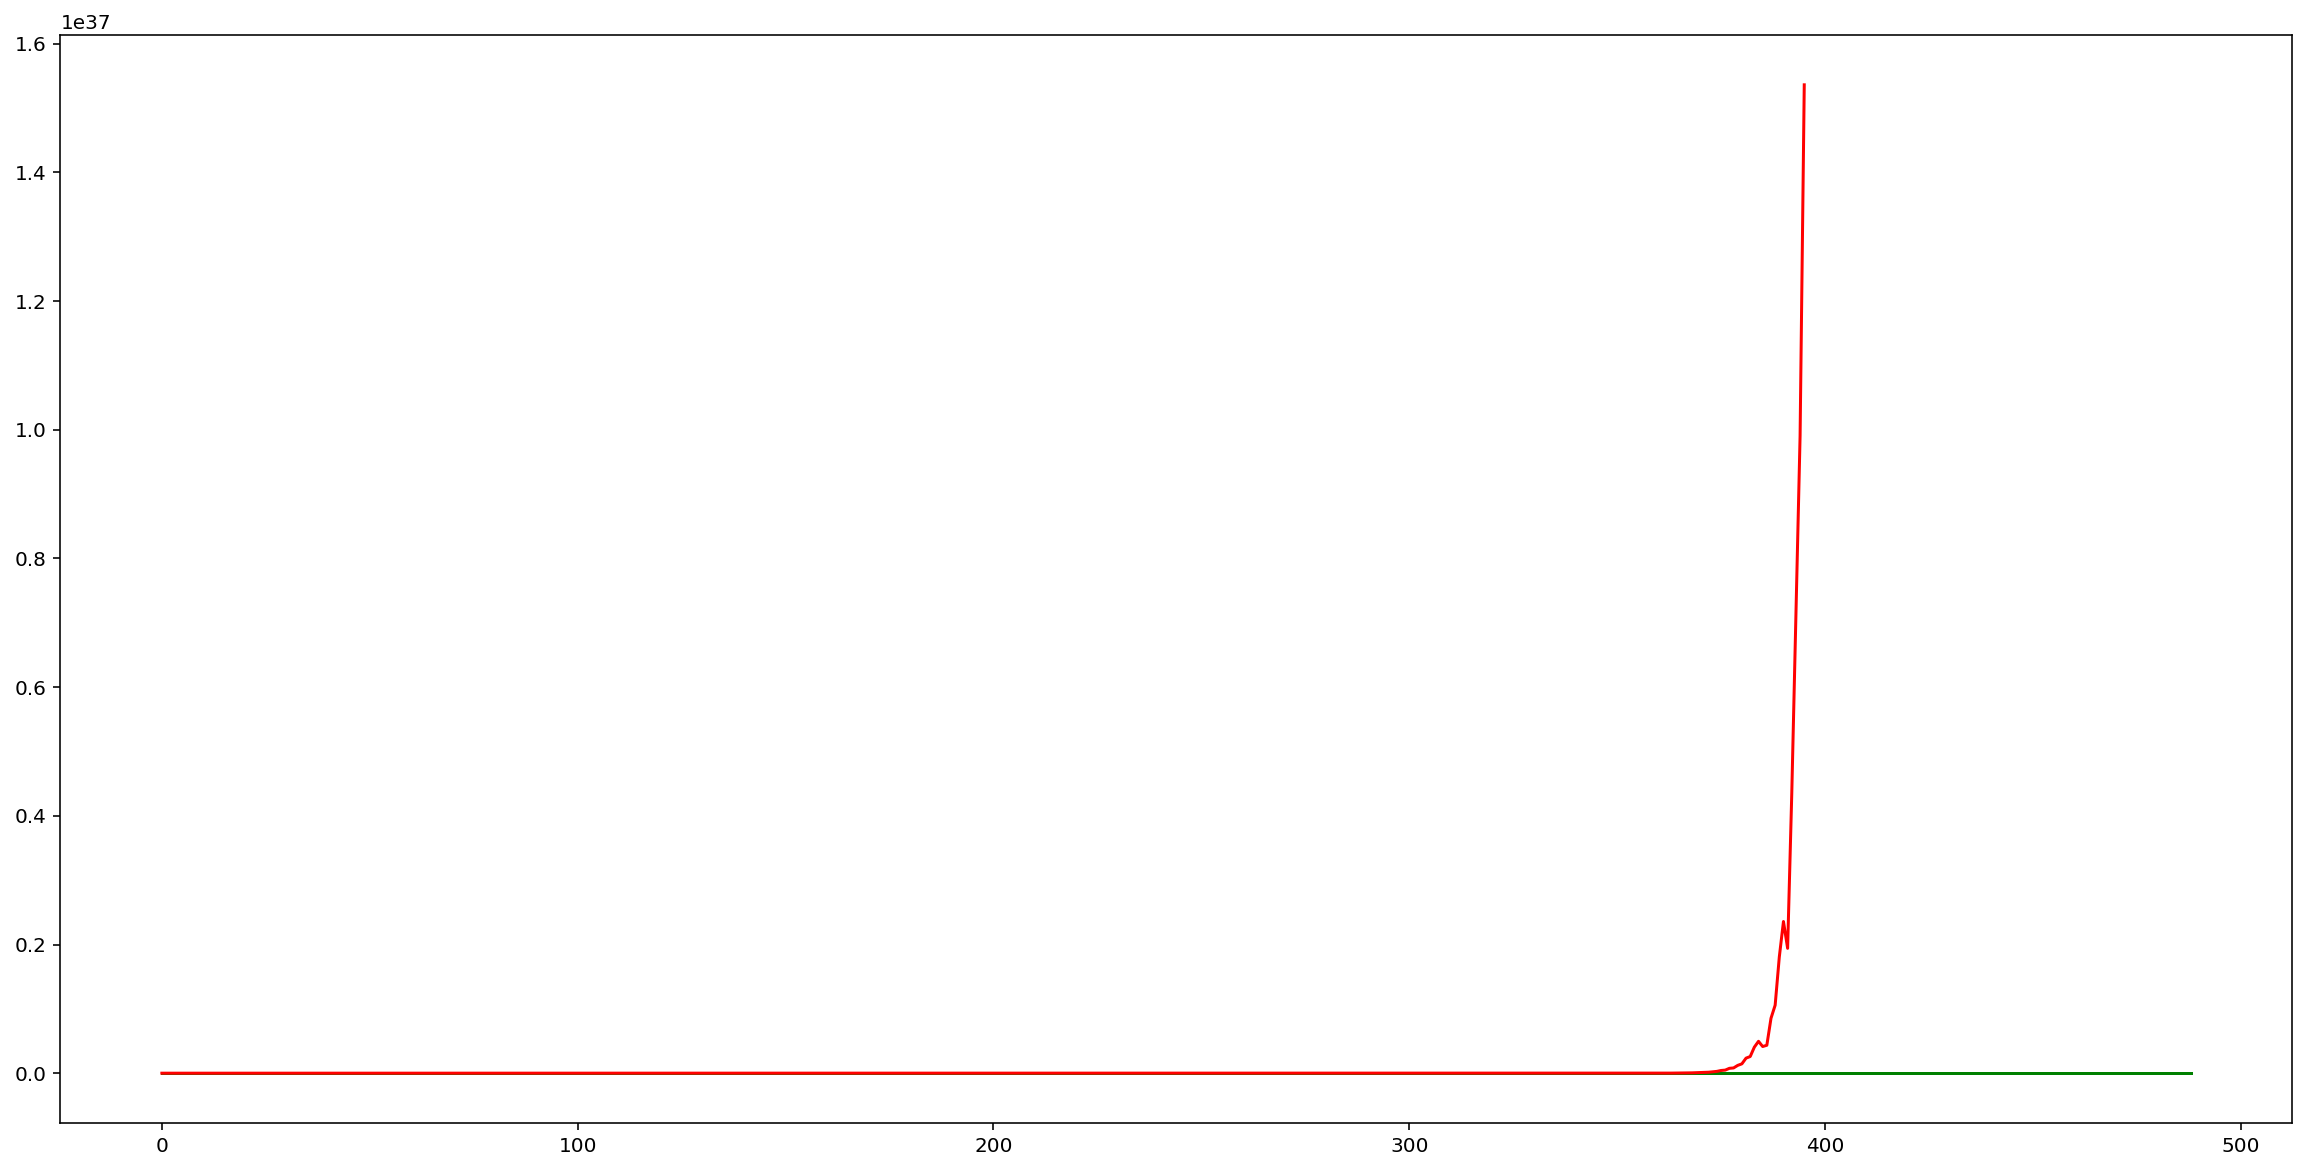

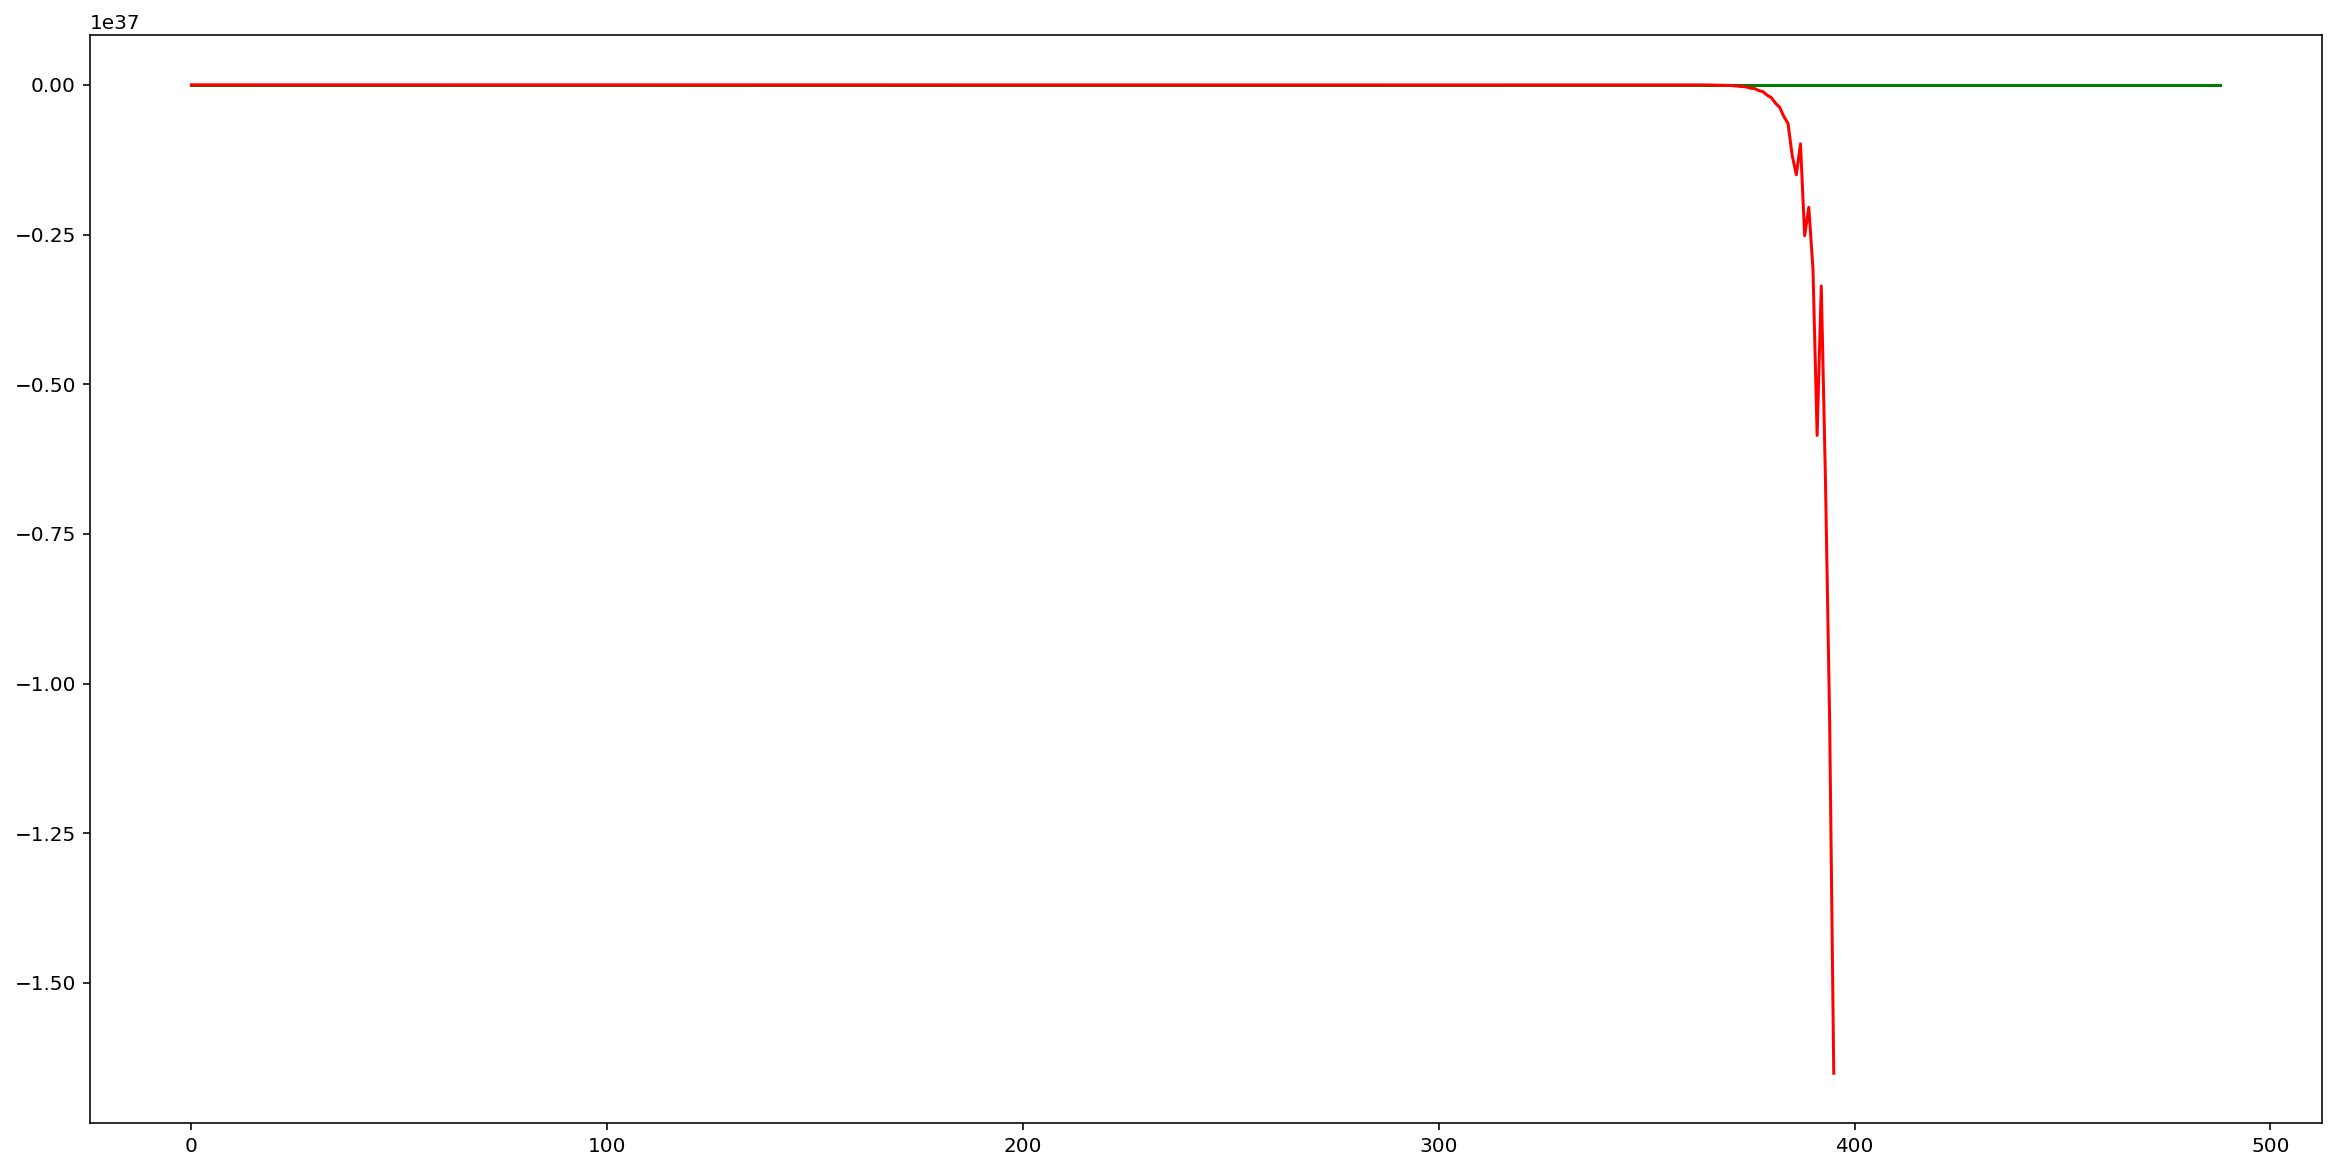

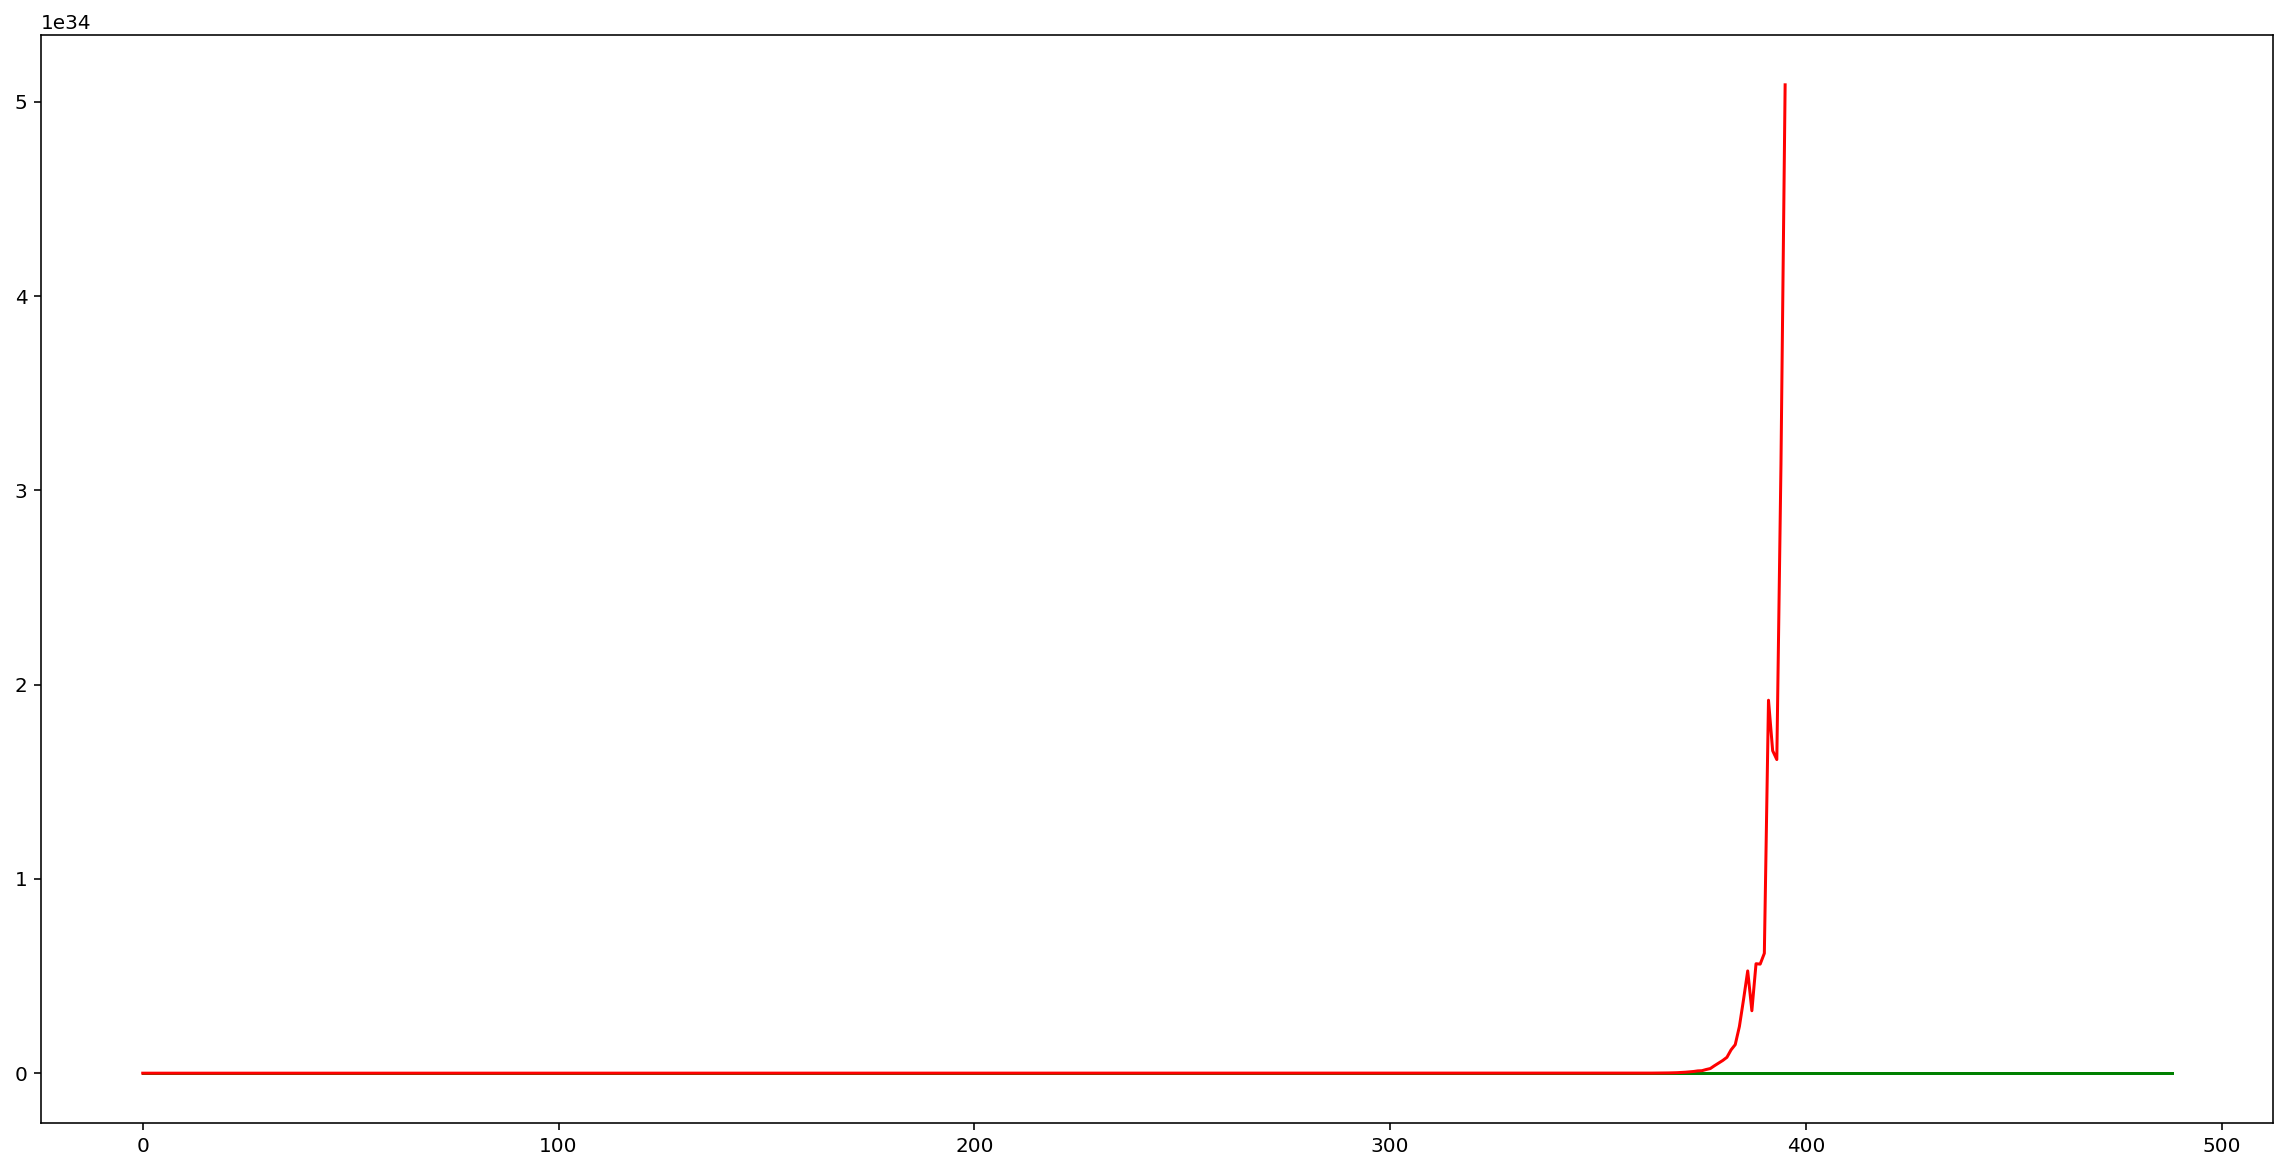

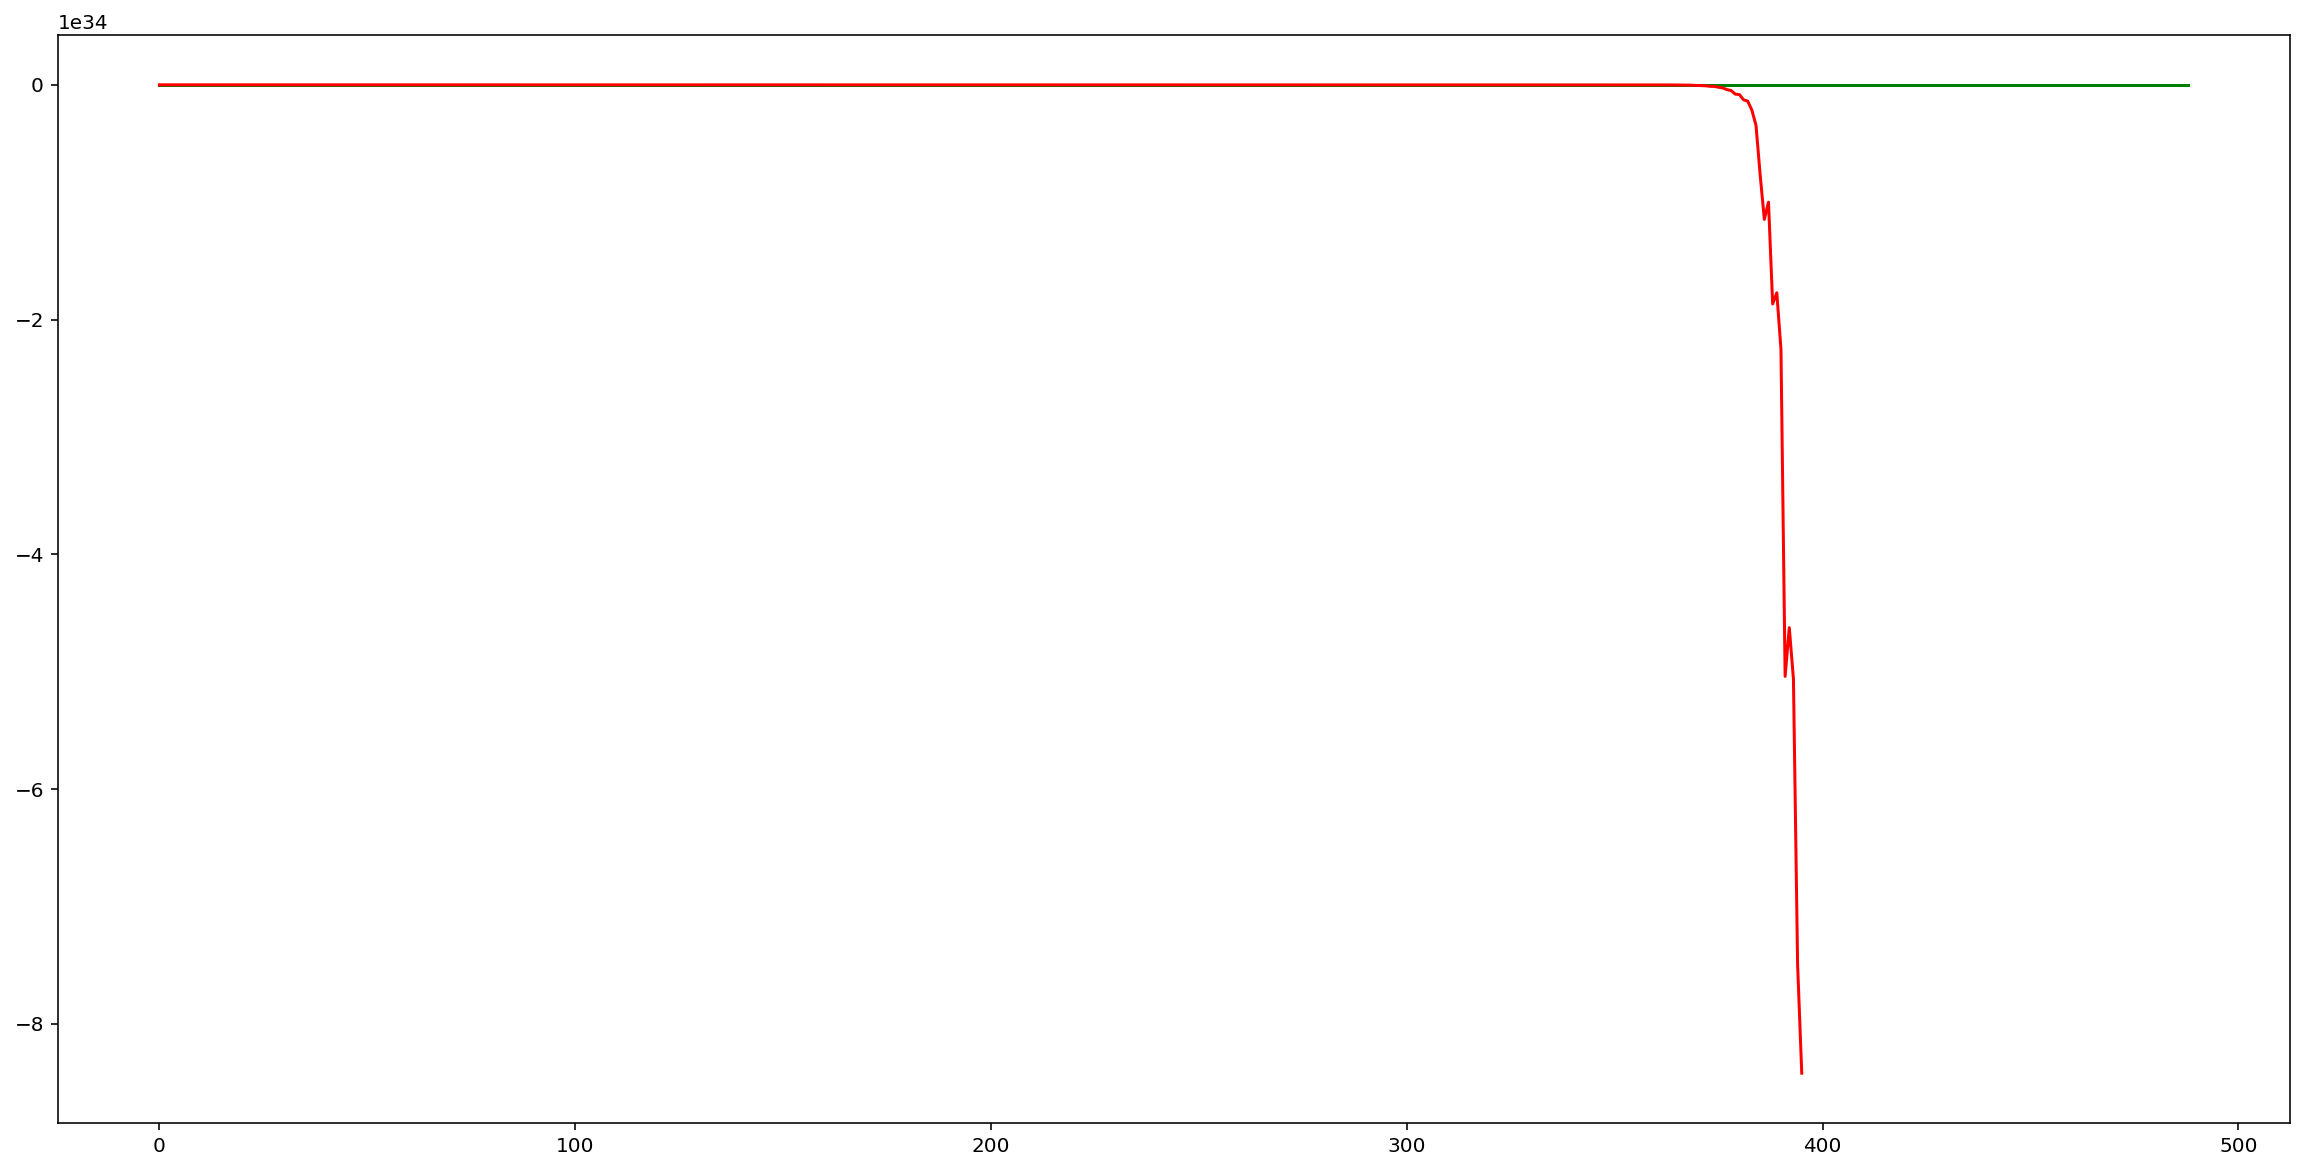

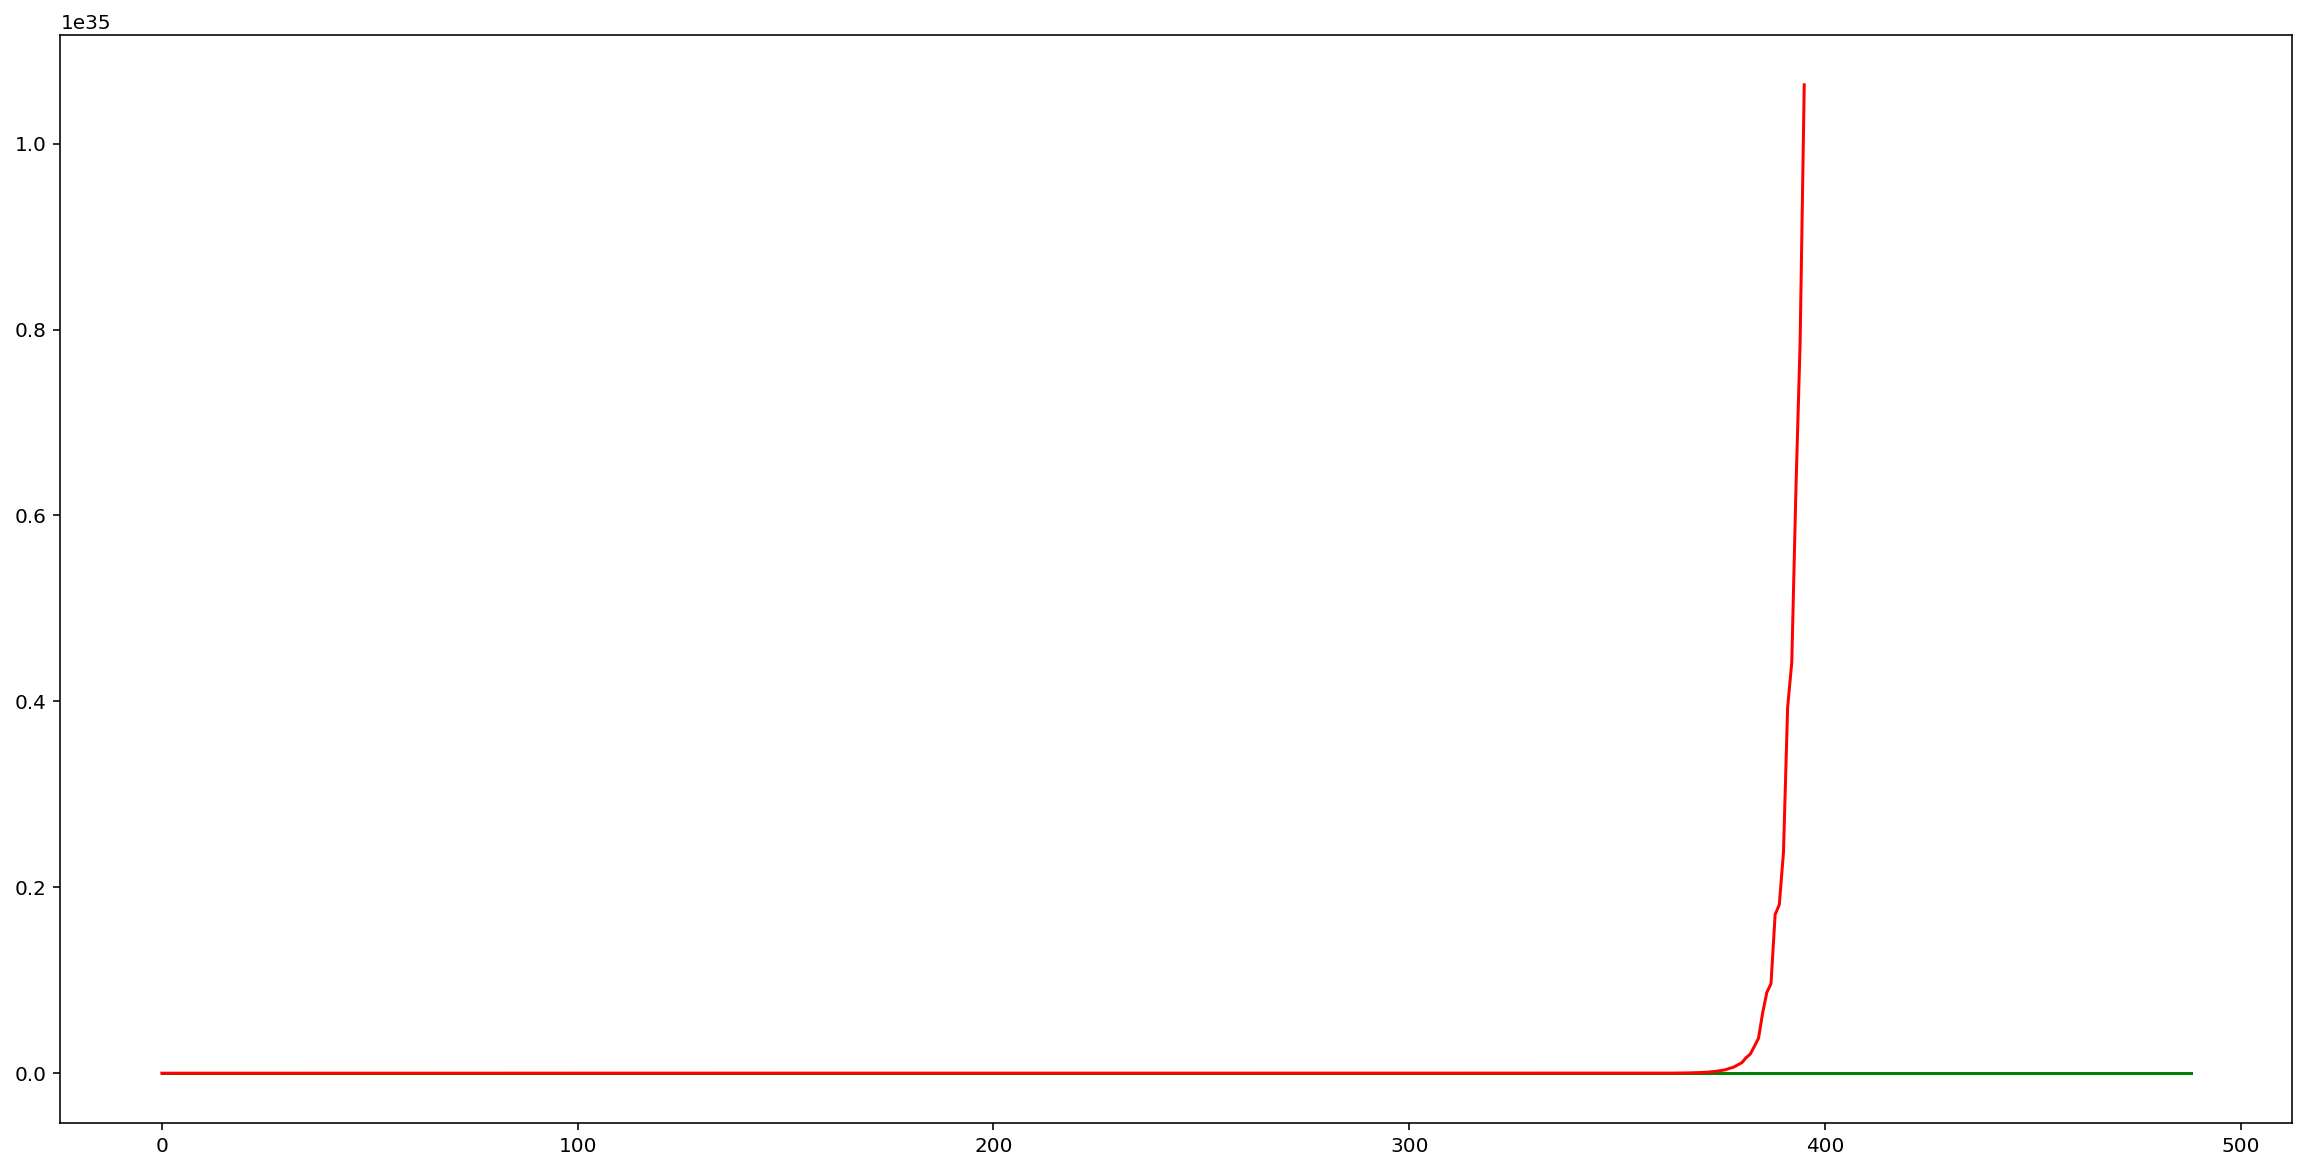

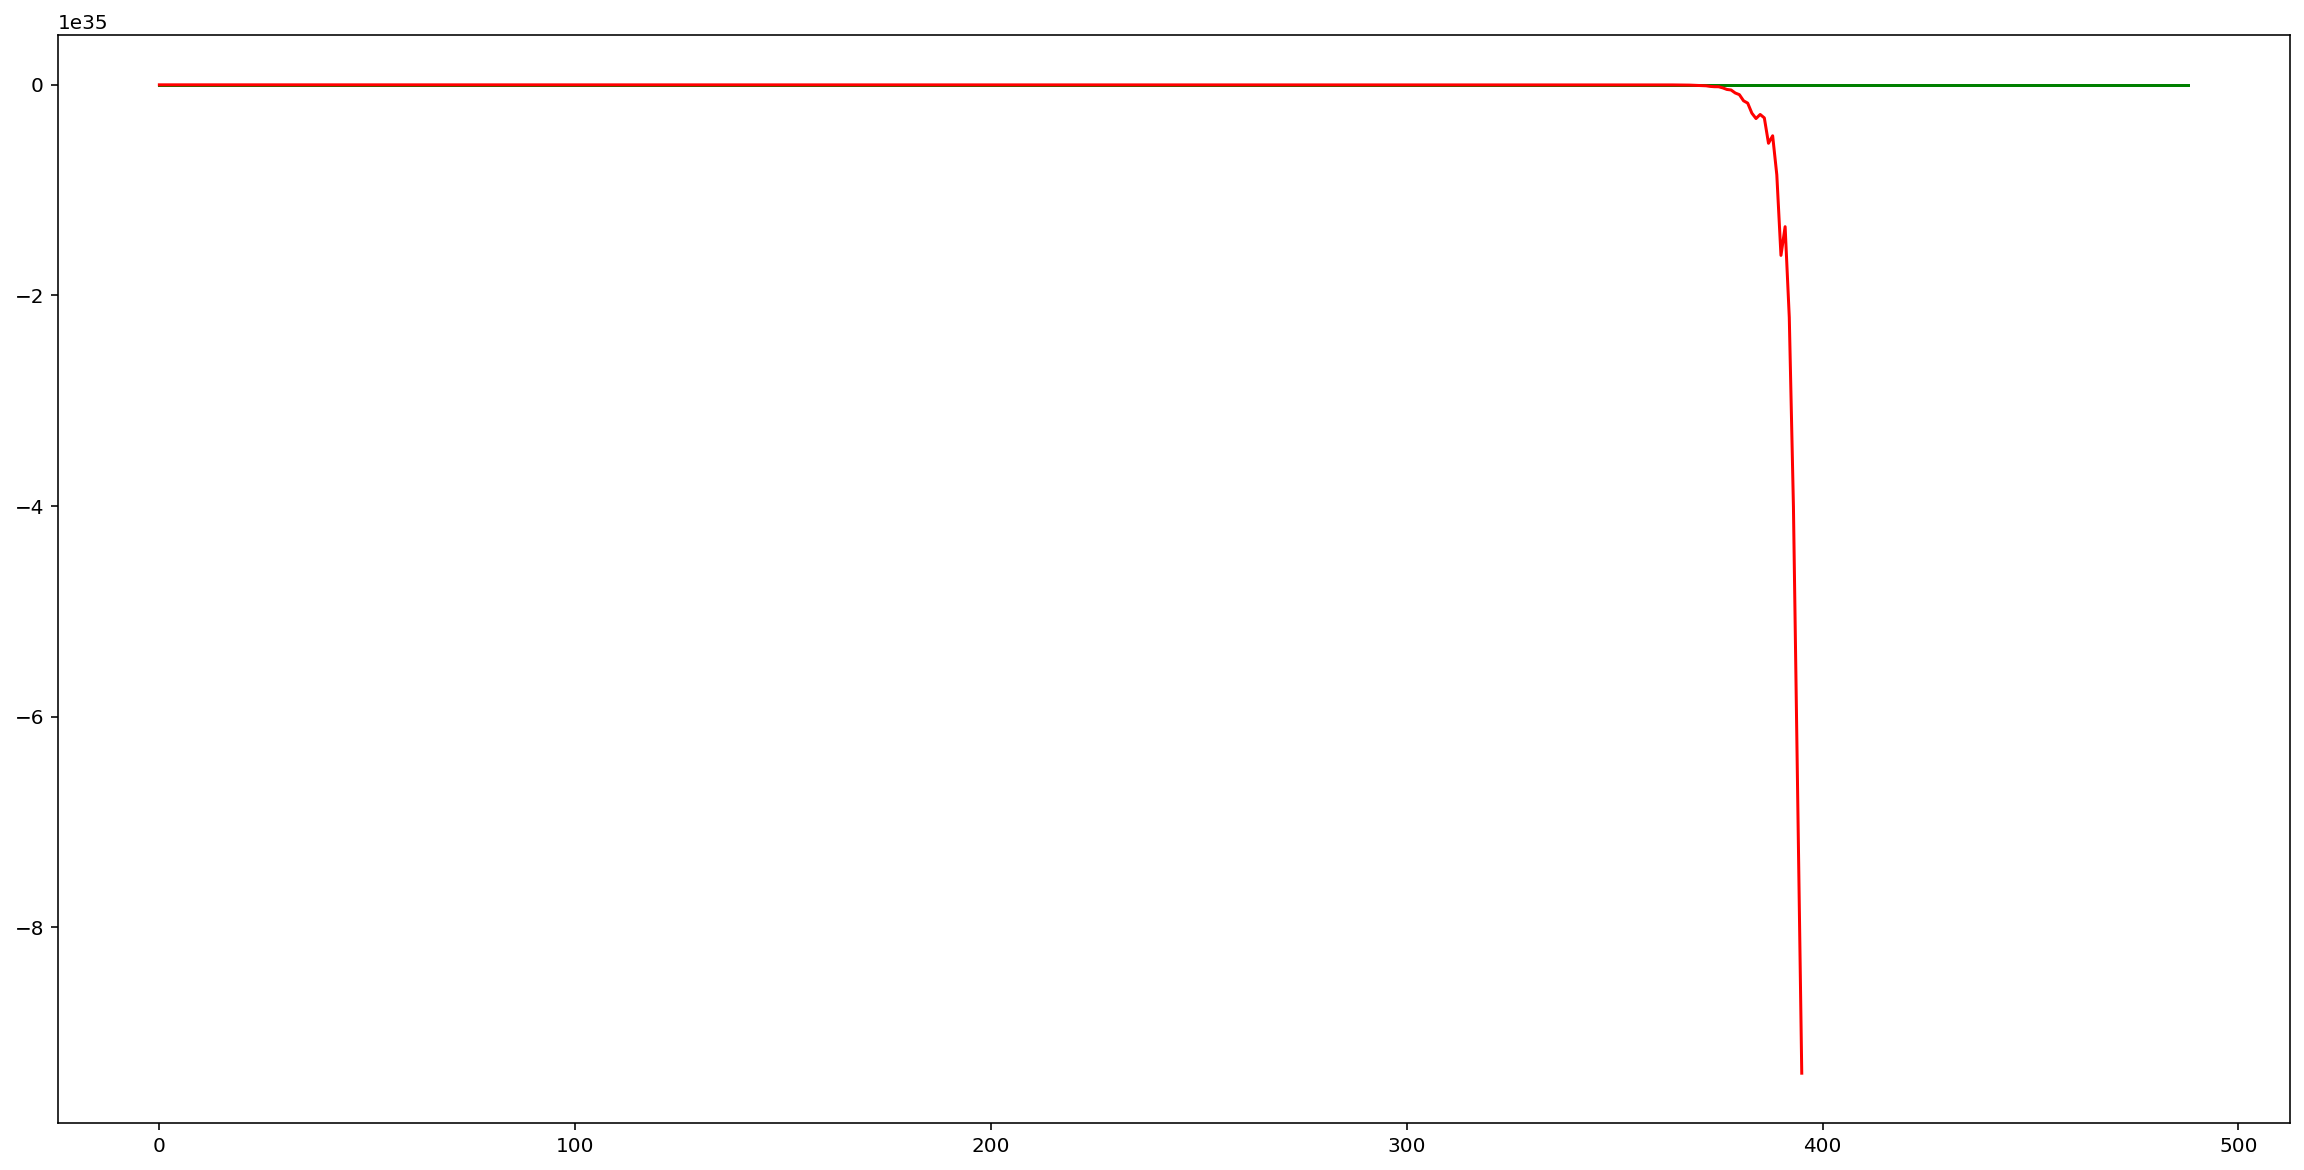

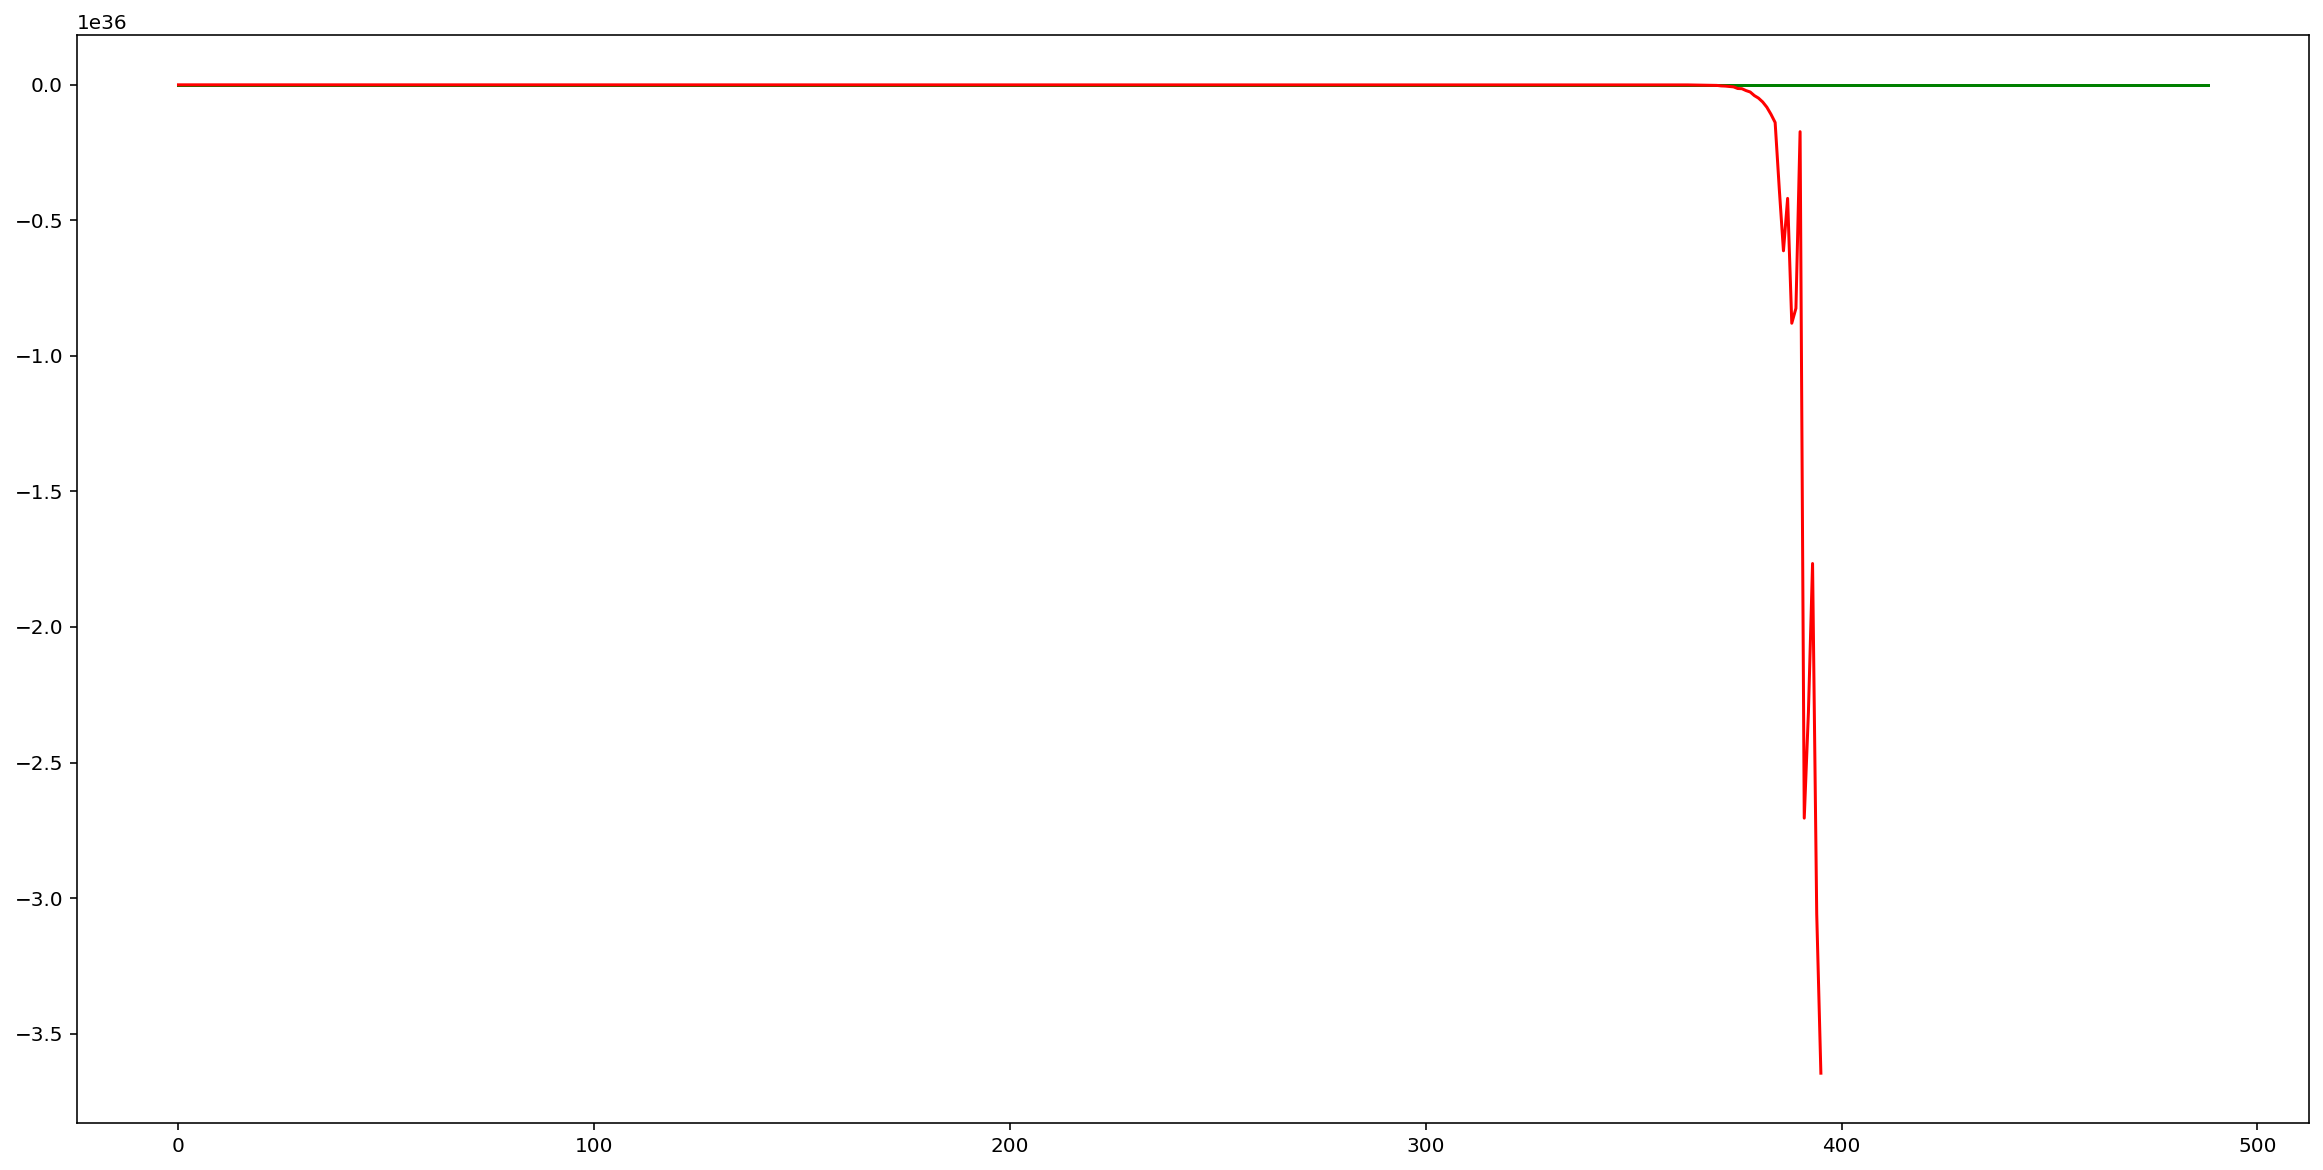

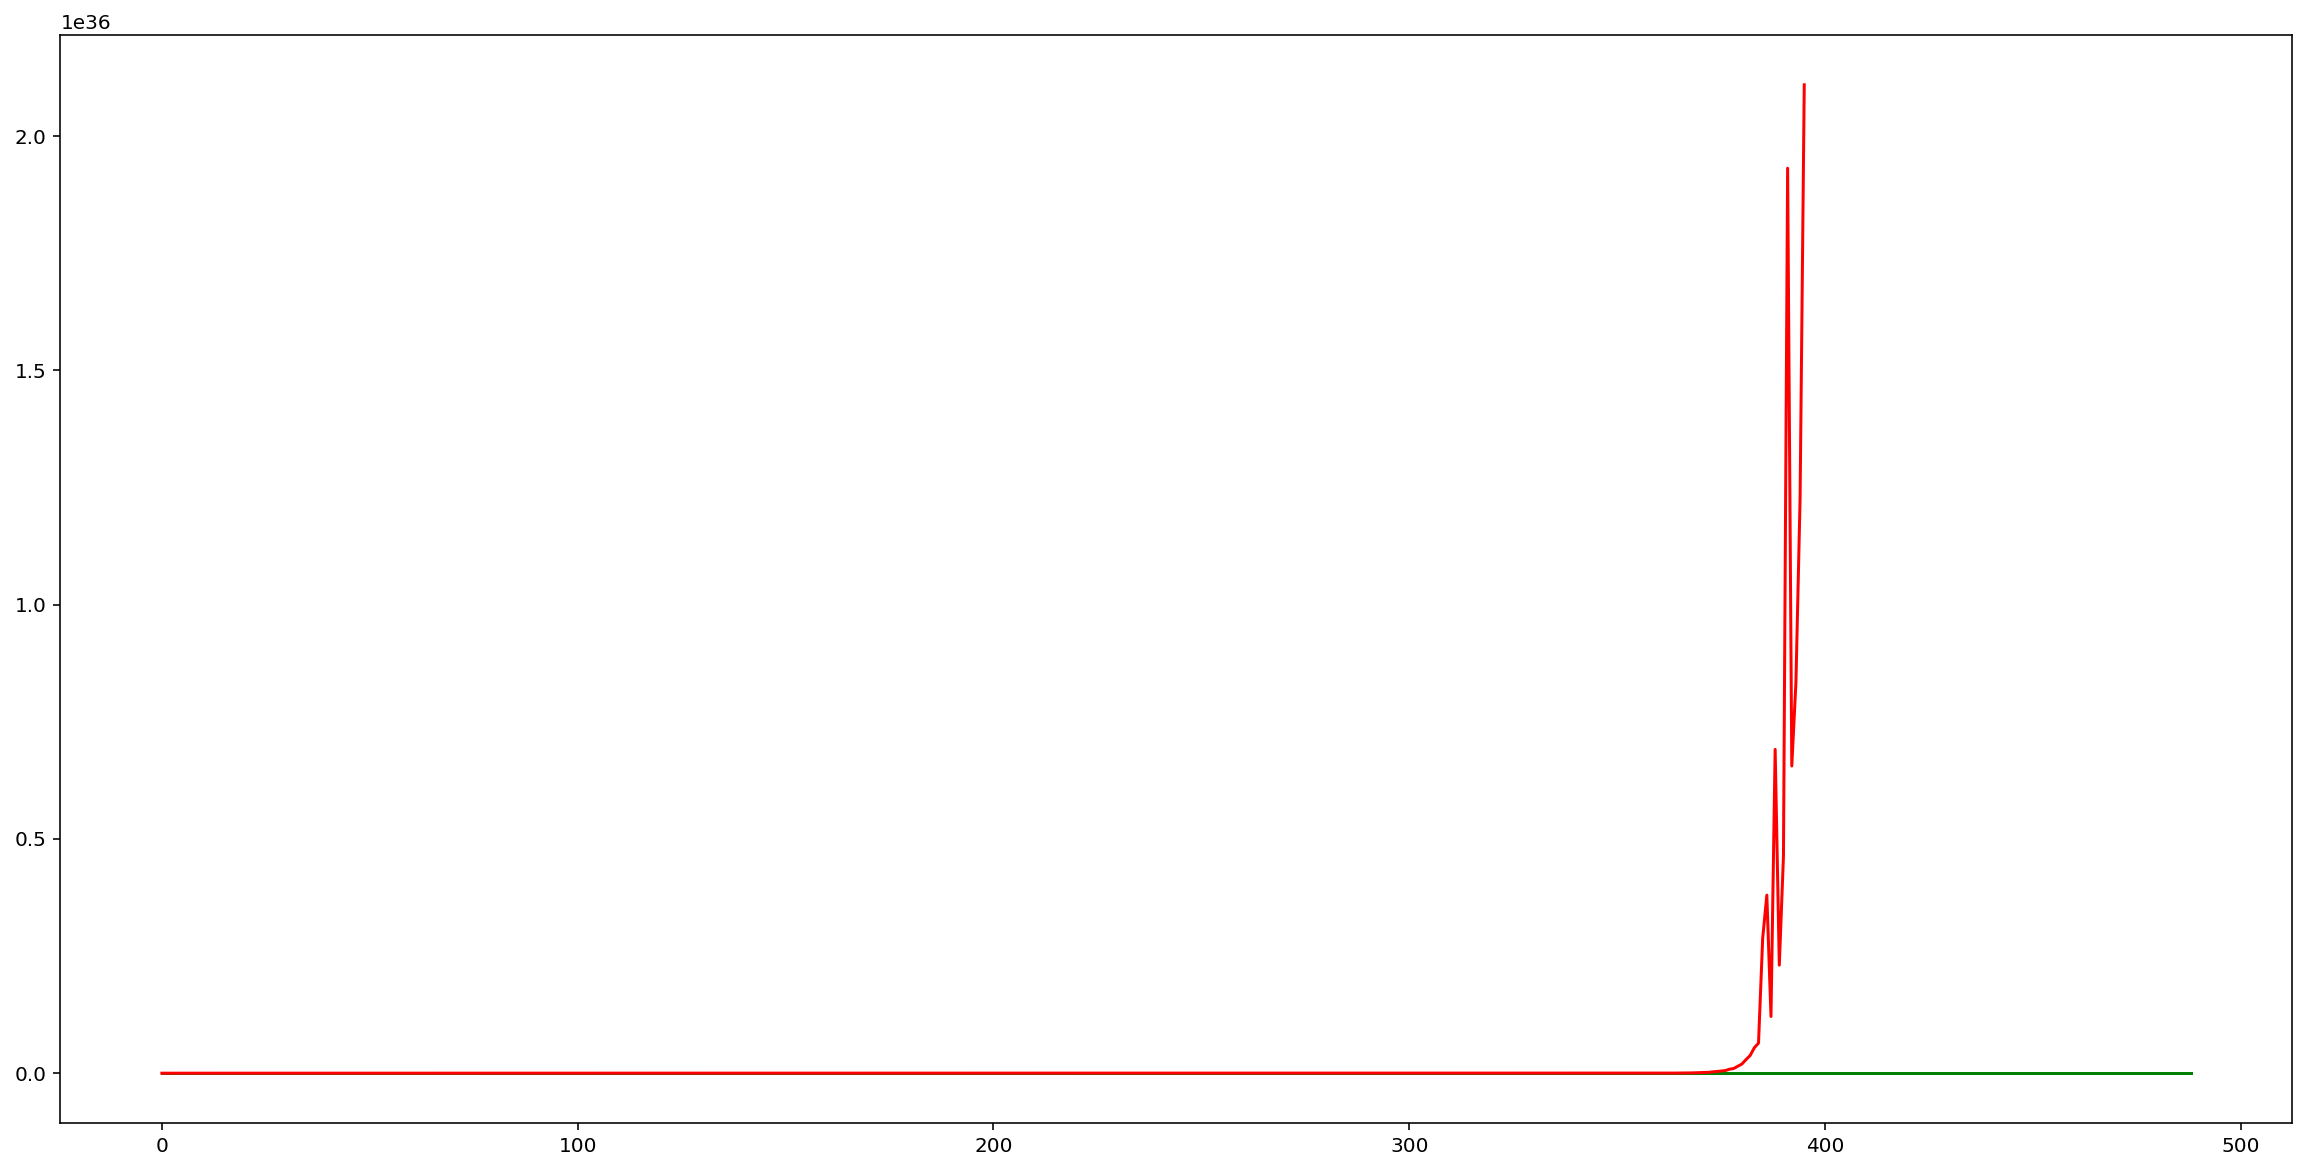

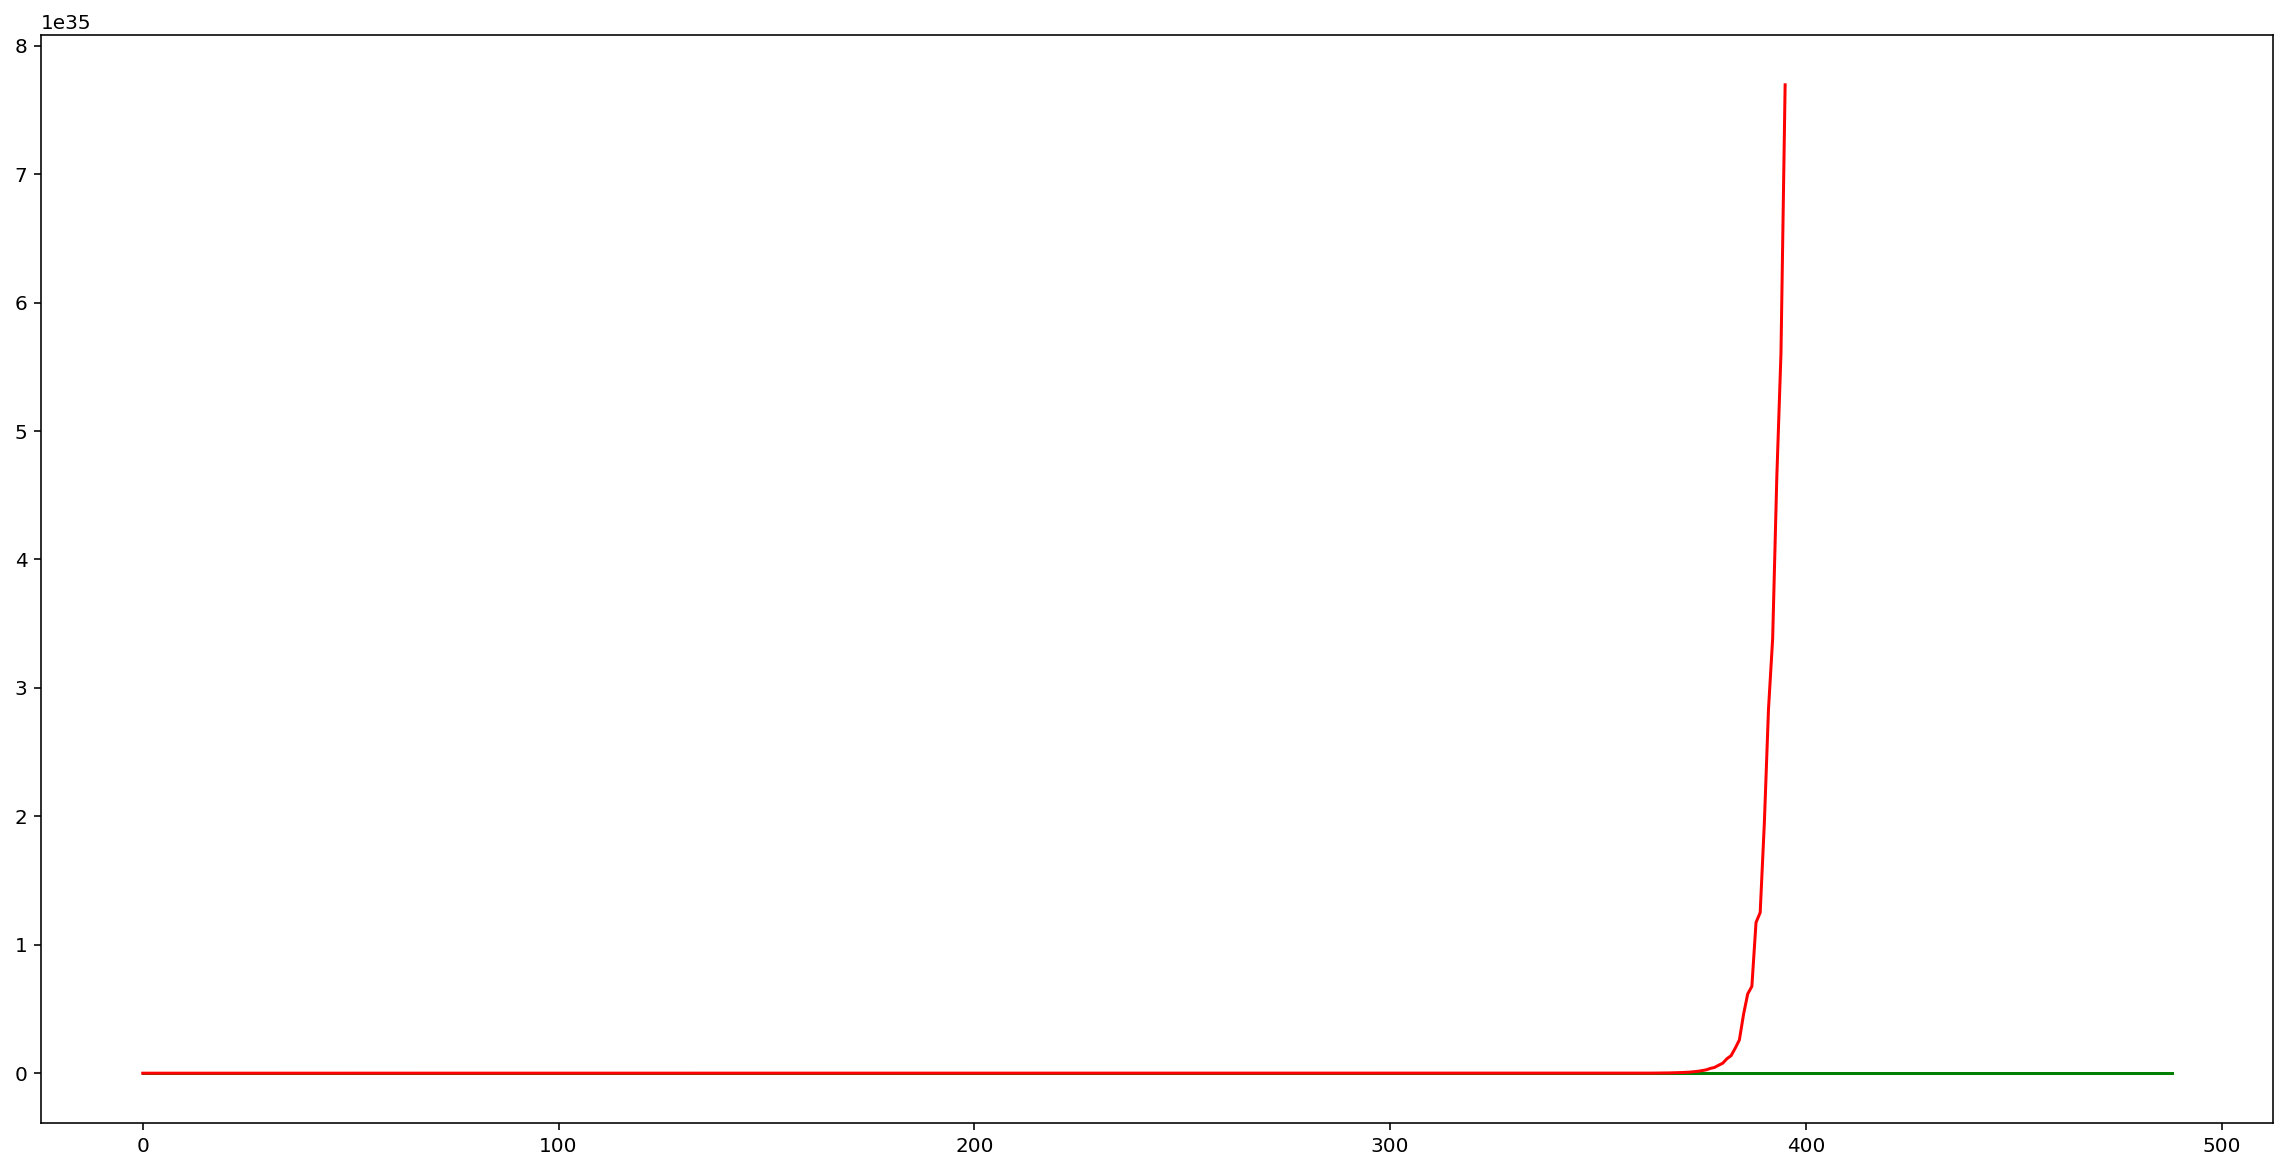

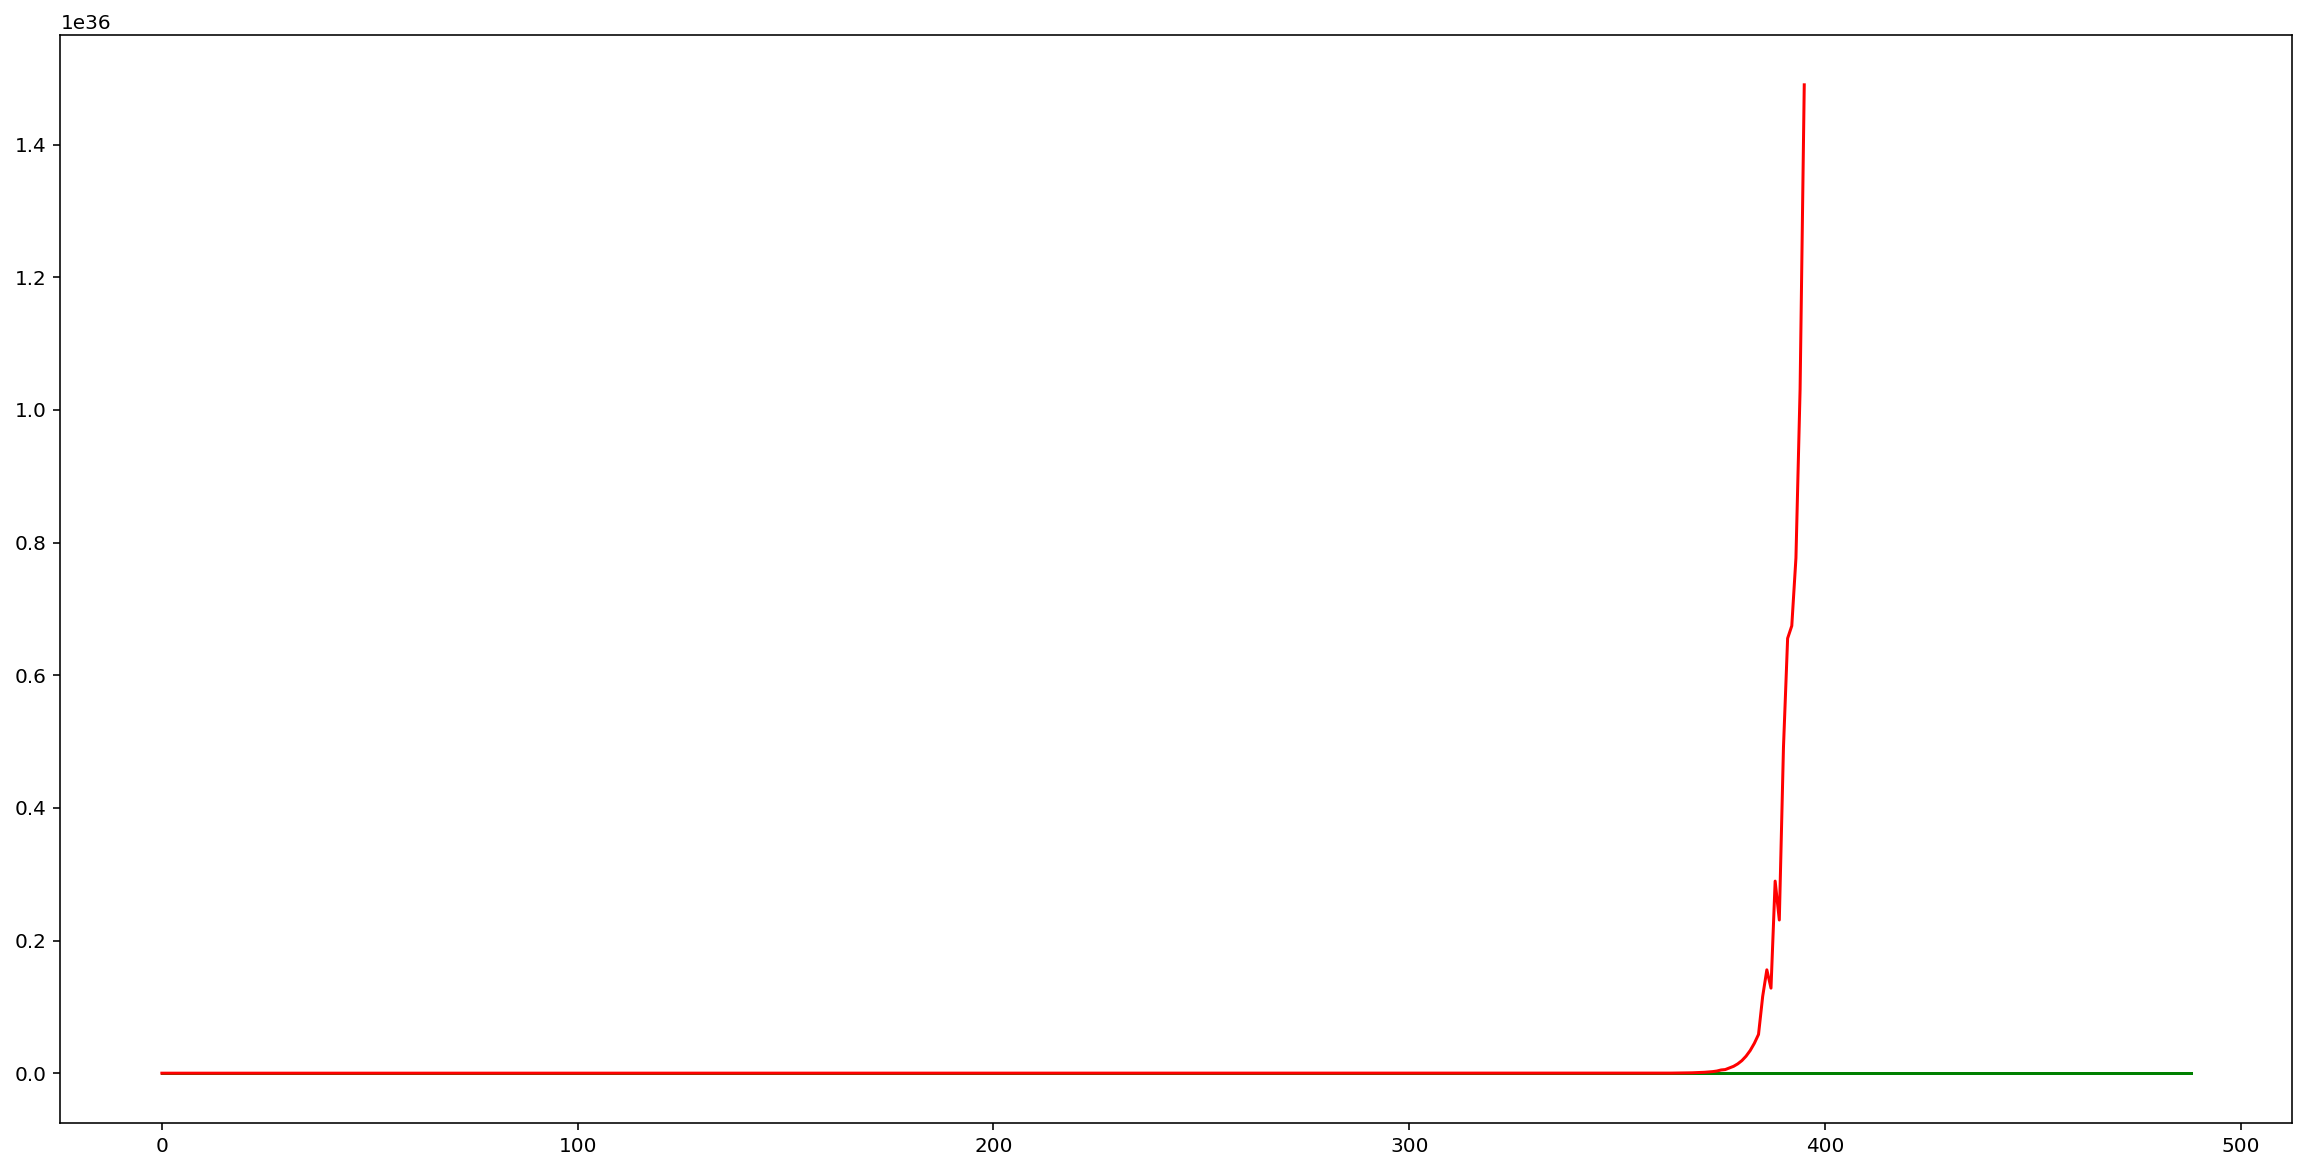

In [ ]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i], color='green')
    plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i], color='red')
    plt.show()

RMSE:

In [ ]:
np.square(y_hat - y_pred).mean(axis = 0)

array([4.1054489e-04, 2.1714706e-04, 2.3859795e-04, 5.0292301e-06,
       4.5099182e-06, 2.1646330e-04, 5.0457567e-04, 1.4138338e-07,
       1.3437028e-07, 2.5426754e-08, 6.4252331e-06, 2.0916881e-04,
       3.4558041e-05, 5.3272055e-07, 1.2286095e-05], dtype=float32)

In [ ]:
np.square(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])).mean(axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in square
  """Entry point for launching an IPython kernel.


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan], dtype=float32)